# Предсказание рейтинга отлеля по данным сайта Booking
Имеется датасет, в котором содержатся сведения о 515 000 отзывов на отели Европы. Обучаемая модель должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. 

В датасете представлены следующие признаки:
  -  *hotel_address* — адрес отеля;
  -  *review_date* — дата, когда рецензент разместил соответствующий отзыв;
  -  *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
  -  *hotel_name* — название отеля;
  -  *reviewer_nationality* — страна рецензента;
  -  *negative_review* — отрицательный отзыв, который рецензент дал отелю;
  -  *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
  -  *positive_review* — положительный отзыв, который рецензент дал отелю;
  -  *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
  -  *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
  -  *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
  -  *total_number_of_reviews* — общее количество действительных отзывов об отеле;
  -  *tags* — теги, которые рецензент дал отелю;
  -  *days_since_review* — количество дней между датой проверки и датой очистки;
  -  *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
  -  *lat* — географическая широта отеля;
  -  *lng* — географическая долгота отеля.

### Загружаем необходимые библиотеки

In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import category_encoders as ce
import copy
import pickle
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats # библиотека для расчетов
import scipy.stats as stats
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
import re  # будем использовать для извлечения чисел из строки
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn import preprocessing# для нормализации, стандартизации
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import matthews_corrcoef
le = preprocessing.LabelEncoder()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import requests
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point        

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


### Читаем исходные данные

In [94]:
input_dir = '/kaggle/input/sf-booking/'
hotels = pd.read_csv(input_dir + 'hotels_train.csv')

# Проверим, есть ли в датасете дубликаты
dupl_columns = list(hotels.columns)
mask = hotels.duplicated(subset=dupl_columns)
hotels_duplicates = hotels[mask]
print(f'Число найденных дубликатов: {hotels_duplicates.shape[0]}') # 307 дубликатов
# Удаляем дубликаты
hotels = hotels.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {hotels.shape[0]}')

display(hotels.head(2))
hotels.info()

Число найденных дубликатов: 307
Результирующее число записей: 386496


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

Есть пропуски в признаках lng и lat - по 2448 строк. 

### Работа с признаком *days_since_review* 
#### (функция *define_days_since_review_num*)
Для начала выполним одно простое преобразование: выделим числовую часть в признаке *days_since_review*.\
Данный признак принимает значения от 0 до 730. \
Рассматривалось два подхода: оставить исходные числовые значения (количество дней) или создать три новых бинарных признака, принимающих значение 1, если количество дней попадает в соответствующий диапазон (от 0 до 240, от 241 до 480, от 481 до 730). \
При построении модели было выяснено, что применение первого подхода приводит к лучшим результатам.\
Также удалим признак *review_date*, однозначно определяемый признаком *date_since_review*.

In [95]:
# Функция выделения числовой части признака days_since_review
def define_days_since_review_num(df):
    df['days_since_review'] = df['days_since_review'].apply(lambda x: re.findall(r'\b\d+\b', x))
    df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x[0]) if len(x)==1 else None)
    df = df.drop(['review_date'], axis = 1)
    return df

hotels = define_days_since_review_num(hotels)
#hotels.head(2)

### Визуализация взаимосвязей некоторых числовых признаков

Text(0.5, 1.0, 'Признаки total_number_of_reviews и additional_number_of_scoring')

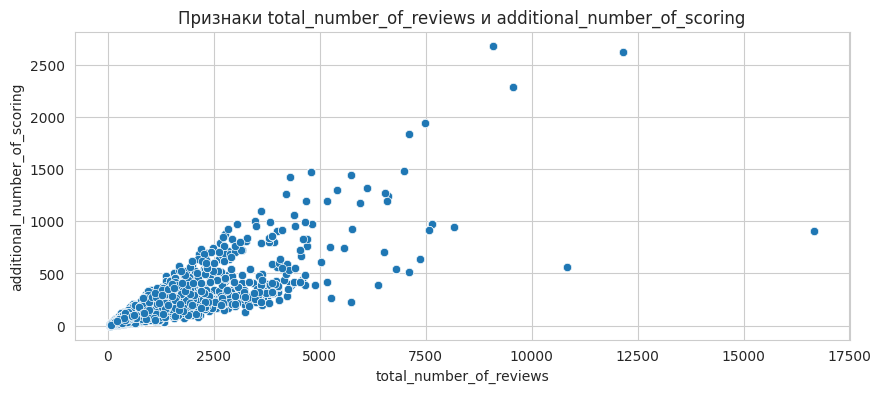

In [96]:
fig_1 = plt.figure(figsize=(10, 4))
scatter_1 = sns.scatterplot(data=hotels, x='total_number_of_reviews', y='additional_number_of_scoring')
scatter_1.set_title('Признаки total_number_of_reviews и additional_number_of_scoring')

# # Построим гистограммы распределений признаков total_number_of_reviews и additional_number_of_scoring
# plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
# plt.hist(hotels['additional_number_of_scoring']) # qq plot
# plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
# plt.hist(hotels['total_number_of_reviews']) # гистограмма распределения признака
# plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
# plt.show() # просмотр графика
# # Видим, что распределения не являются нормальными

По графику наблюдается некоторая закономерность: у отелей с более высоким значением *total_number_of_reviews* и значение *additional_number_of_scoring* выше (если отель популярен, об этом говорят оба признака). 

Text(0.5, 1.0, 'Признаки lat и lng')

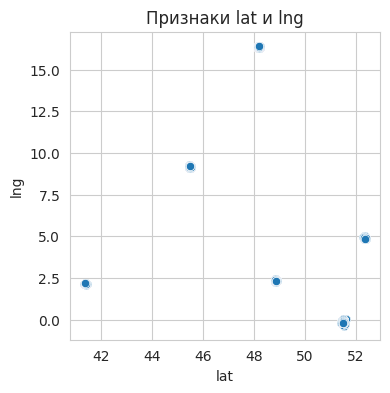

In [97]:
fig_2 = plt.figure(figsize=(4, 4))
scatter_2 = sns.scatterplot(data=hotels, x='lat', y='lng')
scatter_2.set_title('Признаки lat и lng')

Видим, что отели сосредоточены вокруг шести локаций, находящихся на расстоянии друг от друга. Представляется целесообразным создать новые признаки "принадлежности" к этим локациям.\
Ниже будет показано, что в датасете представлены отели из шести стран, которым и соответствуют указанные локации.\
Далее будут созданы признаки стран расположения отелей, *lng* и *lat* будут удалены.

Text(0.5, 1.0, 'Признаки review_total_negative_word_counts и review_total_positive_word_counts')

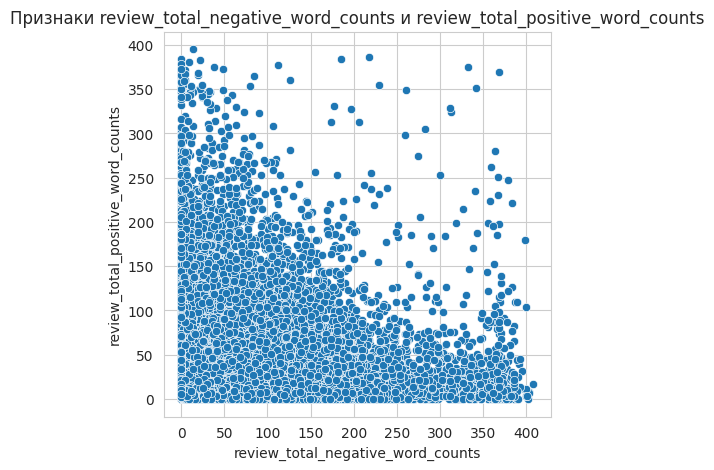

In [98]:
fig_3 = plt.figure(figsize=(5, 5))
scatter_3 = sns.scatterplot(data=hotels, x='review_total_negative_word_counts', y='review_total_positive_word_counts')
scatter_3.set_title('Признаки review_total_negative_word_counts и review_total_positive_word_counts')

# # # Построим гистограммы распределений признаков total_number_of_reviews и additional_number_of_scoring
# # plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
# # plt.hist(hotels['review_total_negative_word_counts']) # qq plot
# # plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
# # plt.hist(hotels['review_total_positive_word_counts']) # гистограмма распределения признака
# # plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
# # plt.show() # просмотр графика
# # # Видим, что распределения не являются нормальными

Наблюдается относительно небольшое количество отзывов, у которых оба признака принимают большие значения (> 200): основная масса точек расположена в левой нижней четверти графика (и в положительном и в отрицательном отзывах менее 200 слов). Точки расположены преимущественно ближе к осям: если количество слов в отрицательном отзыве велико (> 250), то их число в положительном существенно меньше (< 70), и наоборот.

## Работа с признаками *hotel_address*, *lng*, *lat*
#### (функции *define_hotel_country*, *hotel_country_encoder*)

In [99]:
display(hotels['hotel_name'].value_counts())
print()
display(hotels['hotel_address'].value_counts())

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: count, Length: 1492, dtype: int64

hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: count, Length: 1493, dt

Видим, что распределение адресов (за исключением, предположительно, одного адреса) совпадает с распределением названий отелей (что логично). После создания признака страны расположения отеля можно будет удалить признак *hotel_address*, однозначно определяемый признаком *hotel_name*. 

С использованием признака *hotel_address* планируем создать только один признак - страну расположения отеля. \
(Дальше можно было бы попробовать отдельно выделить, например, расположение отелей в крупных городах (Лондоне, Барселоне и др.)). 
Признаки *lat* и *lng* удалим, так как из них не планируется извлекать дополнительную информацию о расположении отлеля.

In [100]:
# Функция определения страны отеля из его адреса
def define_hotel_country(df):
    df['hotel_country'] = df['hotel_address'].apply(lambda x: x.split())
    df['hotel_country'] = df['hotel_country'].apply(lambda x: x[-2]+' '+x[-1] if x[-1]=='Kingdom' else x[-1])
    df = df.drop(['hotel_address', 'lat', 'lng'], axis = 1)
    return df

hotels = define_hotel_country(hotels)
hotels['hotel_country'].value_counts()

hotel_country
United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: count, dtype: int64

Видим, что в датасете представлены отели из шести стран, примерно половина отелей расположены в Великобритании.

Ниже приведен код на случай, если бы стран расположения отелей было существенно больше и их названия состояли из разного количества слов.
Страна в данном случае определяется с использованием признаков lng и lat. \
А для строк, в которых не заполнены lng и lat, страна расположения отеля определяется "вручную" из его адреса, так как координаты не определены всего для 17 отелей (суммарно занимающих почти 2500 строк датасета). Эти отели расположены в трех странах: Австрии, Франции, Испании. 

In [101]:
# # Ниже код, частично позаимствованный со страницы 
# # https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city    
    
# data = requests.get("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson").json()

# countries = {}
# for feature in data["features"]:
#     geom = feature["geometry"]
#     country = feature["properties"]["ADMIN"]
#     countries[country] = prep(shape(geom))

# def get_country(lon, lat):
#     point = Point(lon, lat)
#     for country, geom in countries.items():
#         if geom.contains(point):
#             return country

#     return "unknown"

# # Cоздаем новый признак hotel_country
# hotels['hotel_country'] = hotels.apply(lambda row: get_country(row['lng'], row['lat']), axis=1)
# display(hotels['hotel_country'].value_counts())

# # Посмотрим на отели с пропусками в координатах
# hotels_no_coord = hotels[hotels.isna().any(axis=1)]
# display(hotels_no_coord.head(2))
# display(hotels_no_coord['hotel_address'].value_counts())
# print()
# print('Всего отелей с незаполненными координатами: ', hotels_no_coord['hotel_address'].value_counts().shape[0])

# # Функция определения страны расположения для отелей с пропущенными координатами
# def define_country(address, country):
#     if address in ['Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria', 
#                    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',           
#                    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',      
#                    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',         
#                    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',          
#                    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',               
#                    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',            
#                    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',             
#                    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',               
#                    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',        
#                    'Paragonstra e 1 11 Simmering 1110 Vienna Austria']:
#         return 'Austria' #48.208563 	16.354169
#     elif address in ['4 rue de la P pini re 8th arr 75008 Paris France', 
#                     '23 Rue Damr mont 18th arr 75018 Paris France',
#                     '20 Rue De La Ga t 14th arr 75014 Paris France']:
#         return 'France' #48.845377 	2.325643 	
#     elif address in ['Bail n 4 6 Eixample 08010 Barcelona Spain',
#                     'Sep lveda 180 Eixample 08011 Barcelona Spain',
#                     'Pau Clar s 122 Eixample 08009 Barcelona Spain']:
#         return 'Spain' #41.383012 	2.170070
#     else:
#         return country

# # Определим страны для строк со значением unknown
# hotels['hotel_country'] = hotels.apply(lambda row: define_country(row['hotel_address'], row['hotel_country']), axis=1)
# print('После заполнения пропусков:')
# hotels['hotel_country'].value_counts()

Посмотрим на распределение признака *reviewer_score* по странам расположения отелей.

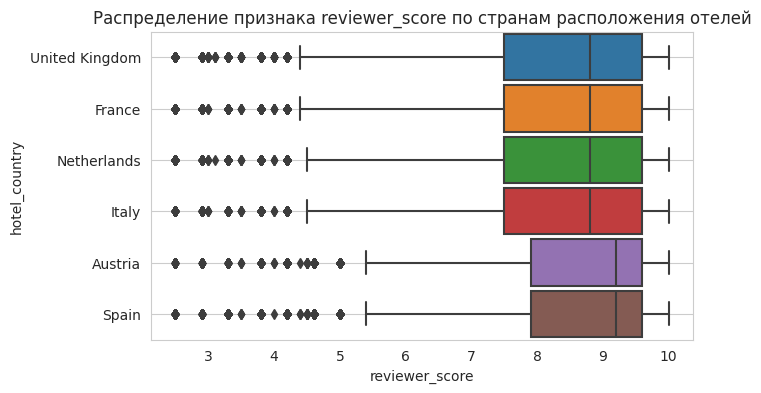

In [102]:
fig_4 = plt.figure(figsize=(7, 4))
boxplot = sns.boxplot(
    data=hotels,
    y='hotel_country',
    x='reviewer_score',
    orient='h',
    width=0.9)
boxplot.set_title('Распределение признака reviewer_score по странам расположения отелей');
boxplot.set_xlabel('reviewer_score');
boxplot.set_ylabel('hotel_country');
boxplot.grid()

Видим, что оценки отелей, расположенных в Австрии и Испании, несколько выше по сравнению с другими странами. 

Так как стран расположения отелей всего шесть, применим к признаку *hotel_country* однократное кодирование. \
Была предпринята попытка удалить признак одной страны (во избежание мультиколлинеарности), но к улучшению результатов обучения модели это не привело. 

In [103]:
# Сначала задаем encoder, чтобы можно было далее применить его к X_val
country_encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True, return_df = True ).fit(hotels['hotel_country']) 

# Функция однократного кодирования hotel_country
def hotel_country_encoder(df):
    df_country = country_encoder.transform(df['hotel_country'])
    df = pd.concat([df, df_country], axis=1)
    return df

hotels = hotel_country_encoder(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,hotel_country,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,United Kingdom,1,0,0,0,0,0
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,United Kingdom,1,0,0,0,0,0


## Работа с признаком *hotel_name*
При обучении модели методом *RandomForestRegressor* было установлено, что использование признаков, полученных с применением двоичного кодирования, не способствует улучшению качества модели. В связи с этим такое кодирование при создании новых признаков применяться не будет.

В датасете представлена информация о 1492 отелях. Самый популярный отель представлен в  3587 отзывах. Можно применить одинарное кодирование к некоторому числу наиболее популярных отелей (для остальных отелей все полученные признаки будут принимать значение 0). Так как отзывы на каждый отель составляют менее 1% всех отзывов (а для менее популярных отелей - существенно меньше 1%), при таком подходе будет создано большое число новых признаков, но будет "охвачено" небольшое количество строк датасета. В связи с вышесказанным, признак *hotel_name* преобразовывать не будем, он будет удален (перед обучением модели).

Гораздо более полезным может быть принимающий для одного и того же отеля одинаковые значения признак *average_score*.

## Работа с признаком *reviewer_nationality*
#### (функции *define_native_hotel*, *correct_nationality*, *reviewer_nationality_encoder*)

Создадим признак *native_hotel*, принимающий значение 1, если отель расположен в родной стране рецензента, иначе - 0.

In [104]:
# Функция создания признака native_hotel:
def define_native_hotel(df):
    def define_native(country, nationality):
        if country == nationality.strip():
            return 1
        else:
            return 0
    
    df['native_hotel'] = df.apply(lambda row: define_native(row['hotel_country'], row['reviewer_nationality']), axis = 1)   
    df = df.drop(['hotel_country'], axis = 1)
    return df

hotels = define_native_hotel(hotels)
display(hotels['native_hotel'].value_counts())

native_hotel
0    252574
1    133922
Name: count, dtype: int64

Примерно треть отзывов написана на отели, находящиеся в родной стране рецензентов. 

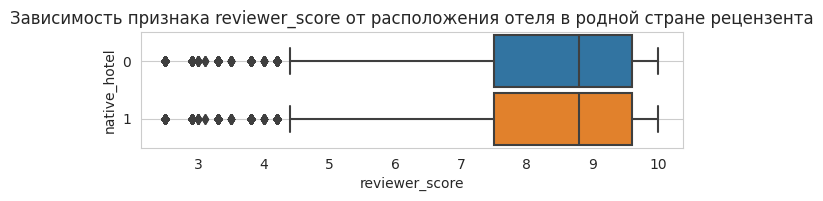

In [105]:
fig_5 = plt.figure(figsize=(7,1.5))
boxplot = sns.boxplot(
    data=hotels,
    y='native_hotel',
    x='reviewer_score',
    orient='h',
    width=0.9)
boxplot.set_title('Зависимость признака reviewer_score от расположения отеля в родной стране рецензента');
boxplot.set_xlabel('reviewer_score');
boxplot.set_ylabel('native_hotel');
boxplot.grid()

Судя по графику, расположение отеля в родной стране рецензента не оказывает существенного влияния на поставленную оценку. Необходимо оценить влияние наличия данного признака на качество модели, при необходимости удалить его.

Посмотрим на распределение национальностей рецензентов.

In [106]:
nationality_counts = hotels['reviewer_nationality'].value_counts().reset_index()
nationality_counts 

,reviewer_nationality,count
0,United Kingdom,183952
1,United States of America,26494
2,Australia,16216
3,Ireland,11119
4,United Arab Emirates,7612
...,...,...
220,Cook Islands,1
221,Guinea,1
222,Comoros,1
223,Anguilla,1


В датасете представлены отзывы рецензентов из 225 стран. Рассмотрим два подхода к работе с этим признаком:
 - Для каждой национальности рассчитать среднее значение *reviewer_score* и заменить национальность этим числом;
 - Однократное кодирование наиболее популярных национальностей.

Также можно было бы, например, разбить страны на группы по уровню жизни и создать признаки принадлежности к этим группам. Информацию можно было бы позаимствовать, например, с сайта https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2023. Однако, стран, представленных в датасете, существенно больше, чем тех, об уровне жизни в которых несложно найти информацию. От этой идеи пришлось отказаться.

В датасете имеется 395 отзывов, в которых признак *reviewer_nationality* не заполнен (принимает значение ' '). Это "значение", а также национальности, которые встречаются в датасете не более 5 раз, переименуем в *other_nationality*.

In [107]:
nationality_counts = nationality_counts[nationality_counts['count'] > 5]
not_rare_nationalities_list = nationality_counts['reviewer_nationality'].tolist()
not_rare_nationalities_list.remove(' ')

def define_other_nationality(df):
    df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in not_rare_nationalities_list else 'other_nationality')
    return df

hotels = define_other_nationality(hotels)

Применим первый подход. Создадим новый признак *nationality_score* - среднее значение *reviewer_score*, для данной национальности пользователя. 

In [108]:
nationalities_df = hotels[['reviewer_nationality', 'reviewer_score']]
nationalities_df = nationalities_df.groupby('reviewer_nationality')['reviewer_score'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False).reset_index()
nationalities_df = nationalities_df.rename(columns = {'mean': 'nationality_score'})
# other_nationality находится на 66 месте по популярности (count = 528) 
#display(nationalities_df)
nationalities_df = nationalities_df.drop(['count'], axis = 1)

# Присоединим nationalities_df к hotels
def add_nationality_score(df):
    df = df.merge(nationalities_df,on = 'reviewer_nationality')
    return df

hotels = add_nationality_score(hotels)

Ниже код для применения второго подхода - однократного кодирования наиболее популярных национальностей. \
Две следующие ячейки выполняются для визуализации, кодирование национальностей (третья ячейка) выполнять в данном случае не будем, так как к существенному улучшению результата после применения первого подхода оно не приводит.

In [109]:
number_of_nationalities = 10 # Задаем количество национальностей, которые предполагается кодировать
# Создаем список наиболее часто встречающихся в датасете национальностей рецензентов
nationality_counts = hotels['reviewer_nationality'].value_counts().reset_index().head(number_of_nationalities)
popular_nationalities_list = nationality_counts['reviewer_nationality'].tolist()

# Функция замены менее популярных национальностей на 'other'
def correct_nationality(df):
    df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in popular_nationalities_list else 'other')
    return df

hotels = correct_nationality(hotels)
hotels['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               183952
other                         109369
 United States of America      26494
 Australia                     16216
 Ireland                       11119
 United Arab Emirates           7612
 Saudi Arabia                   6716
 Netherlands                    6598
 Switzerland                    6492
 Canada                         5977
 Germany                        5951
Name: count, dtype: int64

Чем больше стран будет закодировано, тем больше строк датасета будет задействовано, но при этом будет создано большое количество новых столбцов. Наиболее оптимальное число стран, к которым следует применить одинарное кодирование, можно выяснить при тестировании обученной модели.

В таблице ниже приведено соответствие количества кодируемых популярных национальностей количеству строк датасета, которые не будут задействованы при кодировании (*reviewer_nationality* принимает значение "оther").

| Числоо кодируемых стран | Число "незадействованных" строк |
|---|---|
|60 |  12069 (3.12%)  | 
|40     |  30510 (7.89%)  |
|20  |  69325  (17.92%)     |
|10   |  109479   (28.3%)   |

При обучении установлено, что увеличение числа кодируемых национальностей позволяет повысить точность модели, но весьма несущественно (*score* может быть уменьшен на величину порядка 0.005).

Посмотрим на распределение признака *reviewer_score* в зависимости от национальности рецензента.

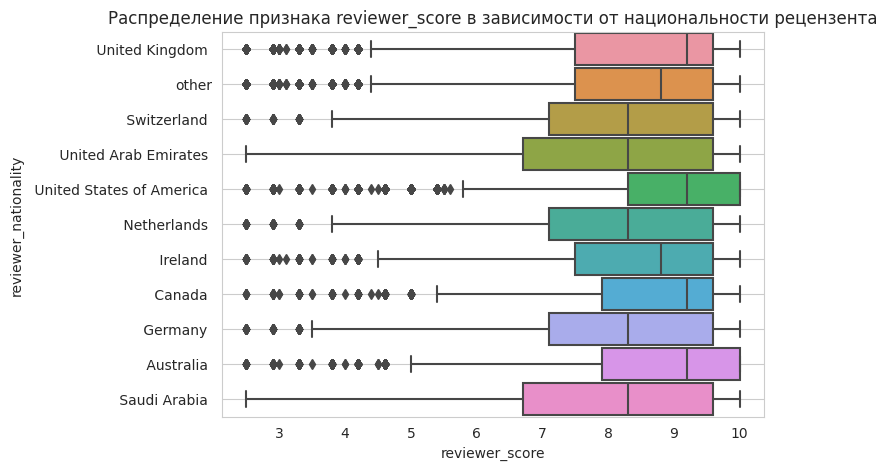

In [110]:
fig_5 = plt.figure(figsize=(7, 5))
boxplot = sns.boxplot(
    data=hotels,
    y='reviewer_nationality',
    x='reviewer_score',
    orient='h',
    width=0.9)
boxplot.set_title('Распределение признака reviewer_score в зависимости от национальности рецензента');
boxplot.set_xlabel('reviewer_score');
boxplot.set_ylabel('reviewer_nationality');
boxplot.grid()

Видим, что распределения *reviewer_score* у рецензентов разных "популярных" национальностей различны. \
Ниже код для однократного кодирования "упрощенного" признака.

In [111]:
# # Сначала задаем encoder, чтобы можно было далее применить его к X_val
# nationality_encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True, return_df = True ).fit(hotels['reviewer_nationality']) 

# # Функция однократного кодирования reviewer_nationality
# def reviewer_nationality_encoder(df):
#     df_nationality = nationality_encoder.transform(df['reviewer_nationality'])
#     df = pd.concat([df, df_nationality], axis=1)
#     df = df.drop(['reviewer_nationality'], axis = 1)
#     return df

# hotels = reviewer_nationality_encoder(hotels)

## Работаем с признаком *total_number_of_reviews_reviewer_has_given*

In [112]:
reviews_counts = hotels['total_number_of_reviews_reviewer_has_given'].value_counts().reset_index()
reviews_counts.sort_values( by = 'total_number_of_reviews_reviewer_has_given')

,total_number_of_reviews_reviewer_has_given,count
0,1,115889
1,2,50362
2,3,35032
3,4,26195
4,5,20580
...,...,...
159,270,2
155,281,2
164,315,2
188,330,1


Пользователи, чьи отзывы представлены в датасете, оставили от 1 до 355 отзывов. 
При работе с признаком можно либо не преобразовывать его, либо представить в виде нескольких категорий (например, "очень активный пользователь", "активный пользователь", "средняя активность", "не очень активный пользователь", "единственный отзыв пользователя"), а затем выполнить однократное кодирование. Количество создаваемых категорий и условия принадлежности к определенной категории могут выбираться различными способами.\
В настоящий момент оставим признак без изменений.

## Работаем с признаками *total_number_of_reviews* и *additional_number_of_scoring*
#### (функция *define_hotel_popularity*)

Оба признака характеризуют количество отзывов на отель, в некоторой степени, его популярность. \
Можно представить признаки в виде нескольких категорий, характеризующих популярность отеля, затем применить однократное кодирование. \
В настоящий момент оставим признаки без изменений и создадим признак суммарного количества отзывов.

In [113]:
def define_hotel_popularity(df):
    df['hotel_popularity'] = df['total_number_of_reviews']+df['additional_number_of_scoring']
    return df

hotels = define_hotel_popularity(hotels)

## Работаем с признаком *tags*
#### (функции  *define_tags_1*, *define_room_tag*, *define_popular_room_tags*, *room_tag_encoder*)

На первом этапе работы с признаком *tags* создадим функцию *define_tags_1*, выполняющую следующие действия:

1. В столбце *tags* содержатся строки, представляющие собой списки из нескольких различных тегов. Преобразуем столбец *tags* в несколько столбцов *tag_0*, ...., *tag_n*, содержащих либо один тег, либо None.

2. При изучении содержимого шести новых столбцов *tag_0*, ..., *tag_5* выяснено, что *tag_5* принимает два значения: "Submitted from a mobile device" или None. К тому же значение "Submitted from a mobile device"принимается большое число раз в *tag_4*. Выделим его в отдельный столбец. Это позволит сократить число тегов для одного отзыва.

3. Рассмотрим столбец *tag_4*. Видим, что остальные значения столбца - количество ночей от 1 до 14. Создадим новый признак "stayed_nights" c количеством ночей, проведенных в отеле.

4. Видим, что в *tag_0* содержится всего 9 различных тегов ("Lisure_trip", "Business_trip" и др.), создадим признаки на их основе. 

In [114]:
# Зададим несколько функций, к которым будем обращаться в функции define_tags_1
# Функция для удаления лишних пробелов у элементов списка
def tag_strip(x):
    y = []
    for n in x:
        n = n.strip()
        y.append(n)
    return y  

# Функция, возвращающая 1, если значение 'Submitted from a mobile device' 
# есть в одном столбце из шести
def submitted_in_tags(tag_0, tag_1, tag_2, tag_3, tag_4, tag_5):
    if 'Submitted from a mobile device' in [tag_0, tag_1, tag_2, tag_3, tag_4, tag_5]:
        return 1
    else:
        return 0

# Функция создания нового признака, содержащего только теги с количеством ночей
def find_stay(tag_0, tag_1, tag_2, tag_3, tag_4):
    tags = [tag_0, tag_1, tag_2, tag_3, tag_4]
    new_tag = ''
    for tag in tags:
        if str(tag)[:7] == 'Stayed ':
            new_tag += tag
    return new_tag  

# Функция заполнения признаков из tag_0 - для создания 9 новых признаков
def create_from_tag_0(tag, tag_0, tag_1, tag_2, tag_3):
    if (tag_0 == tag) or (tag_1 == tag) or (tag_2 == tag) or (tag_3 == tag):
        return 1
    else:
        return 0

# Создадим список из 9 тегов, которые остались в tag_0 после создания признака stayed_nights
tag_0_list = ['Leisure trip', 'Business trip', 'Couple', 'Solo traveler', 'Family with young children',
                 'Group', 'With a pet', 'Family with older children', 'Travelers with friends']

def define_tags_1(df):
# Преобразуем столбец tags в списки
    df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x)) # Преобразуем строки в списки
    df['tags'] = df['tags'].apply(tag_strip)                     # Удаляем лишние пробелы

# Cоздаем множество тегов, считаем его длину
#     tag_set = set(df['tags'][0])
#     for i in range(len(df['tags'])):
#         tag_set = tag_set.union(df['tags'][i])
#     print('Число различных тегов:', len(tag_set)) # Для датасета hotels получим 2368 

#Посмотрим, какое количество тегов может быть указано для одного отзыва
#     df['num_of_tags'] = df['tags'].apply(lambda x: len(x)) # Нужно для анализа количества тегов в одном отзыве
#     print('Распределение числа тегов в одном отзыве:') 
#     display(df['num_of_tags'].value_counts()) # Для датасета hotels получим от 1 до 6 тегов

# Cоздаем шесть новых столбцов с тегами (разбиваем списки тегов)
    df['tag_0'] = df['tags'].apply(lambda x: x[0])
    df['tag_1'] = df['tags'].apply(lambda x: x[1] if len(x)>1 else None)
    df['tag_2'] = df['tags'].apply(lambda x: x[2] if len(x)>2 else None)
    df['tag_3'] = df['tags'].apply(lambda x: x[3] if len(x)>3 else None)
    df['tag_4'] = df['tags'].apply(lambda x: x[4] if len(x)>4 else None)
    df['tag_5'] = df['tags'].apply(lambda x: x[5] if len(x)>5 else None)
    
    df['submitted_from_a_mobile_device'] = df.apply(lambda row: submitted_in_tags(row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3'], row['tag_4'], row['tag_5']), axis=1)
    df['stayed_nights'] = df.apply(lambda row: find_stay(row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3'], row['tag_4']), axis=1) 

    #display(hotels['stayed_nights'].value_counts()) #Видим, что со слова Stayed начинаются только теги, касающиеся количества ночей.

    df['stayed_nights'] = df['stayed_nights'].apply(lambda x: re.findall(r'\b\d+\b', x))
    df['stayed_nights'] = df['stayed_nights'].apply(lambda x: int(x[0]) if len(x)==1 else None)

# заменяем пропущенные значения средним без округления до целого
    df['stayed_nights'] = df['stayed_nights'].fillna(df['stayed_nights'].mean()) 

# Заменим в оставшихся столбцах с тегами "использованные" значения на None
    df['tag_0'] = df['tag_0'].apply(lambda x: None if (str(x)[:7]=='Stayed ')|(x=='Submitted from a mobile device') else x)
    df['tag_1'] = df['tag_1'].apply(lambda x: None if (str(x)[:7]=='Stayed ')|(x=='Submitted from a mobile device') else x)
    df['tag_2'] = df['tag_2'].apply(lambda x: None if (str(x)[:7]=='Stayed ')|(x=='Submitted from a mobile device') else x)
    df['tag_3'] = df['tag_3'].apply(lambda x: None if (str(x)[:7]=='Stayed ')|(x=='Submitted from a mobile device') else x)
    
    df['leisure_trip'] = df.apply(lambda row: create_from_tag_0('Leisure trip', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['business_trip'] = df.apply(lambda row: create_from_tag_0('Business trip', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['couple'] = df.apply(lambda row: create_from_tag_0('Couple', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['solo_traveler'] = df.apply(lambda row: create_from_tag_0('Solo traveler', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['family_with_young_children'] = df.apply(lambda row: create_from_tag_0('Family with young children', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['group'] = df.apply(lambda row: create_from_tag_0('Group', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['with_a_pet'] = df.apply(lambda row: create_from_tag_0('With a pet', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['family_with_older_children'] = df.apply(lambda row: create_from_tag_0('Family with older children', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df['travelers_with_friends'] = df.apply(lambda row: create_from_tag_0('Travelers with friends', row['tag_0'], row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
  
    # Удаляем "использованные" теги 
    df['tag_1'] = df['tag_1'].apply(lambda x: None if x in tag_0_list else x)
    df['tag_2'] = df['tag_2'].apply(lambda x: None if x in tag_0_list else x)
    df['tag_3'] = df['tag_3'].apply(lambda x: None if x in tag_0_list else x)
    df = df.drop(['tags', 'tag_5', 'tag_4', 'tag_0'], axis = 1) 
    return df

In [115]:
# Применяем функцию к hotels
hotels = define_tags_1(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,native_hotel,nationality_score,hotel_popularity,tag_1,tag_2,tag_3,submitted_from_a_mobile_device,stayed_nights,leisure_trip,business_trip,couple,solo_traveler,family_with_young_children,group,with_a_pet,family_with_older_children,travelers_with_friends
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531,1,0,0,0,0,0,1,8.488676,2575,None,Studio Suite,None,1,2.0,1,0,1,0,0,0,0,0,0
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,203,1,0,0,0,0,0,1,8.488676,1660,None,Standard Double Room,None,0,1.0,0,1,1,0,0,0,0,0,0


In [116]:
display(hotels['tag_1'].value_counts())
print()
display(hotels['tag_2'].value_counts())
print()
display(hotels['tag_3'].value_counts())

tag_1
Double Room                                        834
Standard Double Room                               711
Superior Double Room                               618
Deluxe Double Room                                 587
Double or Twin Room                                439
                                                  ... 
Luxury Twin Room Solarium                            1
Business Apartment with Public Transport Ticket      1
One Bedroom Apartment with City View                 1
Double Room Audacieuse                               1
Double Room Mus e d Orsay with Spa Bath              1
Name: count, Length: 895, dtype: int64

tag_2
Double Room                                     25497
Standard Double Room                            23389
Superior Double Room                            22843
Deluxe Double Room                              17985
Double or Twin Room                             16325
                                                ...  
Two Adjoining Rooms                                 1
Luxury Suite antique theme                          1
Suite with River View                               1
Two Adjoining Rooms with Dock View Main Deck        1
Executive Double Room Non Smoking                   1
Name: count, Length: 2320, dtype: int64

tag_3
Double or Twin Room                            60
Superior Double Room                           57
Double Room                                    55
Standard Double Room                           50
Classic Double Room                            45
                                               ..
Twin Room with Extra Bed                        1
Classic Queen Room                              1
Small Double or Twin Room                       1
Junior Suite 2 Adults                           1
Classic Double or Twin Room with Spa Access     1
Name: count, Length: 247, dtype: int64

Похоже, все оставшиеся теги характеризуют тип комнаты. Ниже проверка, может ли быть несколько таких тегов у одного отзыва.\
(Ячейка не обязательна к выполнению).

In [117]:
# Функция подсчета количества непустых тегов у одного отзыва
def define_num_of_room_tags (tag_1, tag_2, tag_3):
    num = 0
    if tag_1 is not None:
        num += 1
    if tag_2 is not None:
        num += 1
    if tag_3 is not None:
        num += 1   
    return num    

hotels['num_of_room_tags'] = hotels.apply(lambda row: define_num_of_room_tags(row['tag_1'], row['tag_2'], row['tag_3']), axis=1)   
display(hotels['num_of_room_tags'].value_counts()) 
hotels = hotels.drop(['num_of_room_tags'], axis = 1)

num_of_room_tags
1    386350
0       146
Name: count, dtype: int64

Видим, что у каждого отзыва не более одного тега, характеризующего тип комнаты. \
Переносим все теги в один признак

In [118]:
# Функция записи тегов типа комнаты в новый признак 
def fill_room_tag(tag_1, tag_2, tag_3):
    if tag_1 is not None:
        return tag_1
    elif tag_2 is not None:
        return tag_2
    elif tag_3 is not None:
        return tag_3
    else:
        return 'No Room tag'

# Функция создания признака room_tag
def define_room_tag(df):
    df['room_tag'] = df.apply(lambda row: fill_room_tag(row['tag_1'], row['tag_2'], row['tag_3']), axis=1)
    df = df.drop(['tag_1', 'tag_2', 'tag_3'], axis = 1)
    return df
hotels = define_room_tag(hotels)
display(hotels['room_tag'].value_counts())

room_tag
Double Room                           26386
Standard Double Room                  24150
Superior Double Room                  23518
Deluxe Double Room                    18612
Double or Twin Room                   16824
                                      ...  
Suite with Executive Lounge Access        1
Suite Free Executive Lounge Access        1
Suite Designer                            1
Duplex King Suite 3 Adults                1
Executive Double Room Non Smoking         1
Name: count, Length: 2329, dtype: int64

Всего в датасете представлено 2329 типов номеров. При работе с признаком *room_tag* можно применить **три подхода**: 

1. "Привязка" к каждому типу номера величины, характеризующей связь *room_tag* с *reviewer_score*;
2. Создание признаков типа номера, объединяющих несколько типов номеров (например, по содержанию слов "double", "superior", "classic" и т.д.);
3. Однократное кодирование наиболее часто встречающихся типов номеров.

#### Применяем первый подход
("Привязка" к каждому типу номера величины, характеризующей связь *room_tag* с *reviewer_score*)

Будут созданы новые признаки:
 - *room_tag_score_mean* - среднее значение *reviewer_score* по всем номерам данного типа;
 - *room_tag_delta_mean* - среднее значение *delta* (величины, показывающей, насколько оценка конкретного отзыва отличается от среднего рейтинга отеля) по всем номерам данного типа.

Значения признаков вычисляются для типов номеров, которые встречаются в датасете не менее 5 раз (это ограничение можно попробовать изменить по результатам обучения модели), для менее популярных типов номеров признаки заполняются средними по всему датасету.
 

In [119]:
# Временно создаем признак delta = reviewer_score - average_score,
# показывающий, насколько оценка конкретного отзыва отличается от среднего рейтинга отеля
hotels['delta'] = hotels['reviewer_score'] - hotels['average_score']

# Выполняем группировку по признаку room_tag
room_tag_df = hotels.groupby('room_tag').agg(room_tag_count=('room_tag', 'count'), 
                                             room_tag_delta_mean=('delta', 'mean'), 
                                             room_tag_score_mean=('reviewer_score', 'mean'))
room_tag_df = room_tag_df.sort_values(by='room_tag_count', ascending = False).reset_index()

# Вычисляем средние значения reviewer_score и delta по всему датасету,
# чтобы далее заполнить пропуски для непопулярных room_tag
reviewer_score_mean = hotels['reviewer_score'].mean()
delta_mean = hotels['delta'].mean()

hotels = hotels.drop(['delta'], axis = 1)

# Поставим ограничение на минимальное число присутствий типа номера в датасете (не менее 5)
room_tag_df_cut = room_tag_df[room_tag_df['room_tag_count']>=5]
room_tag_df_cut

,room_tag,room_tag_count,room_tag_delta_mean,room_tag_score_mean
0,Double Room,26386,-0.014402,8.282642
1,Standard Double Room,24150,0.011470,8.256530
2,Superior Double Room,23518,0.011021,8.507717
3,Deluxe Double Room,18612,-0.002670,8.369541
4,Double or Twin Room,16824,0.036020,8.436442
...,...,...,...,...
1660,Deluxe Double Room with Connecting Doors,5,0.640000,8.440000
1661,Park Suite,5,0.540000,9.600000
1662,Prestige Room Swimming Pool Hammam Access upon...,5,0.120000,9.420000
1663,Executive Suite with Spa Bath,5,0.360000,9.760000


Посмотрим на средний *reviewer_score* для типа номера в зависимости от популярности типа номера.

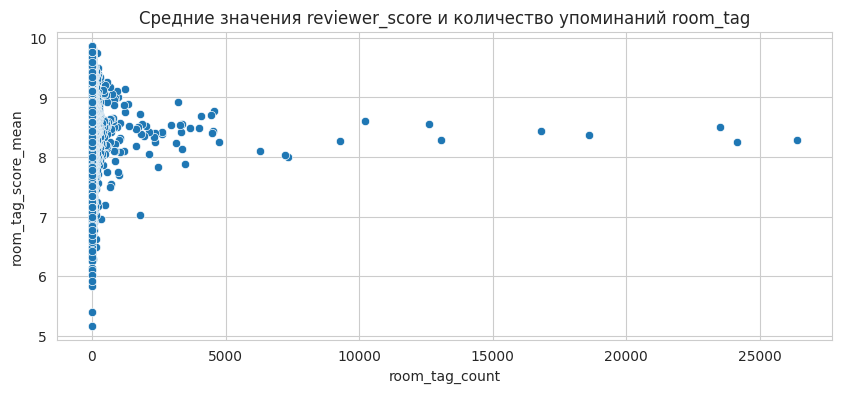

In [120]:
plt.figure(figsize=(10, 4))
sns.set_style("whitegrid")
scatter = sns.scatterplot(data=room_tag_df_cut, x='room_tag_count', y='room_tag_score_mean')
scatter.set_title('Средние значения reviewer_score и количество упоминаний room_tag')

room_tag_df_cut = room_tag_df_cut.drop(['room_tag_count'], axis = 1)

Видим, что экстремальные (как высокие, так и низкие) оценки достигаются для менее популярных типов номеров. 

In [121]:
# Функция добавления признаков room_tag_score и room_tag_delta
def define_room_tag_features(df):
    df = df.merge(room_tag_df_cut, on = 'room_tag', how='left').reset_index(drop=True)
    df['room_tag_delta_mean'] = df['room_tag_delta_mean'].fillna(delta_mean)
    df['room_tag_score_mean'] = df['room_tag_score_mean'].fillna(reviewer_score_mean)
    return df

hotels = define_room_tag_features(hotels)
hotels.head(4)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,native_hotel,nationality_score,hotel_popularity,submitted_from_a_mobile_device,stayed_nights,leisure_trip,business_trip,couple,solo_traveler,family_with_young_children,group,with_a_pet,family_with_older_children,travelers_with_friends,room_tag,room_tag_delta_mean,room_tag_score_mean
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,531,1,0,0,0,0,0,1,8.488676,2575,1,2.0,1,0,1,0,0,0,0,0,0,Studio Suite,0.115285,9.046041
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,203,1,0,0,0,0,0,1,8.488676,1660,0,1.0,0,1,1,0,0,0,0,0,0,Standard Double Room,0.011470,8.256530
2,32,8.9,Legend Saint Germain by Elegancia,other,No kettle in room,6,406,No Positive,0,14,7.5,289,0,1,0,0,0,0,0,8.459094,438,1,3.0,1,0,0,1,0,0,0,0,0,Modern Double Room Echo,-0.000122,8.397299
3,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,681,0,1,0,0,0,0,0,8.488676,641,0,1.0,1,0,0,1,0,0,0,0,0,Standard Room with 1 Double Bed,-0.011226,7.491728


Ниже код для применения **второго подхода**.\
При анализе результатов обучения модели было установлено, что добавление столбцов, харакетризующих тип номера по выбранным ключевым словам, не приводит к существенному улучшению качества модели. Принято решение отказаться от добавления указанных признаков.

In [122]:
# # Функция создания признаков по ключевым словам типа комнаты
# def define_room_class(df):
#     df['room_standard'] = df['room_tag'].apply(lambda x: 1 if 'Standard' in x else 0)
#     df['room_classic'] = df['room_tag'].apply(lambda x: 1 if 'Classic' in x else 0)
#     df['room_superior'] = df['room_tag'].apply(lambda x: 1 if 'Superior' in x else 0)
#     df['room_junior'] = df['room_tag'].apply(lambda x: 1 if 'Junior' in x else 0)
#     df['room_deluxe'] = df['room_tag'].apply(lambda x: 1 if 'Deluxe' in x else 0)
#     #df['room_king'] = df['room_tag'].apply(lambda x: 1 if 'King' in x else 0)
#     #df['room_queen'] = df['room_tag'].apply(lambda x: 1 if 'Queen' in x else 0)
#     df['room_executive'] = df['room_tag'].apply(lambda x: 1 if 'Executive' in x else 0)
#     df['room_small'] = df['room_tag'].apply(lambda x: 1 if 'Small' in x else 0)
#     df['room_basic'] = df['room_tag'].apply(lambda x: 1 if 'Basic' in x else 0)
#     df['room_comfort'] = df['room_tag'].apply(lambda x: 1 if 'Comfort' in x else 0)
#     df['room_club'] = df['room_tag'].apply(lambda x: 1 if 'Club' in x else 0)
#     df['room_cosy'] = df['room_tag'].apply(lambda x: 1 if 'Cosy' in x else 0)
#     df['room_economy'] = df['room_tag'].apply(lambda x: 1 if 'Economy' in x else 0)
#     df['room_large'] = df['room_tag'].apply(lambda x: 1 if 'Large' in x else 0)
#     df['room_luxury'] = df['room_tag'].apply(lambda x: 1 if 'Luxury' in x else 0)
#     df['room_premier'] = df['room_tag'].apply(lambda x: 1 if 'Premier' in x else 0)
#     df['room_compact'] = df['room_tag'].apply(lambda x: 1 if 'Compact' in x else 0)
#     df['room_premium'] = df['room_tag'].apply(lambda x: 1 if 'Premium' in x else 0)
#     df['room_business'] = df['room_tag'].apply(lambda x: 1 if 'Business' in x else 0)
    
#     df['room_class_sum'] =  df['room_standard']+df['room_classic']+df['room_superior']\
#     +df['room_junior']+df['room_deluxe']+df['room_executive']\
#     +df['room_small']+df['room_basic']+df['room_comfort']+df['room_club']+df['room_cosy']\
#     +df['room_economy']+df['room_large']+df['room_luxury']+df['room_premier']+df['room_compact']\
#     +df['room_premium']+df['room_business']# +df['room_king']+df['room_queen']
#     return df

# hotels = define_room_class(hotels)
#hotels['room_class_sum'].value_counts()

#### Применяем третий подход
(Однократное кодирование наиболее часто встречающихся типов номеров)

In [123]:
number_of_room_tags = 10 # Задаем количество room_tags, которые будем кодировать

# Создаем список наиболее часто встречающихся в датасете типов комнат
room_tag_counts = hotels['room_tag'].value_counts().reset_index().head(number_of_room_tags)
popular_room_tags_list = room_tag_counts['room_tag'].tolist()

# Функция замены менее популярных room_tags на 'other'
def correct_room_tag(df):
    df['room_tag'] = df['room_tag'].apply(lambda x: x if x in popular_room_tags_list else 'other')
    return df

hotels = correct_room_tag(hotels)
hotels['room_tag'].value_counts()

room_tag
other                           224503
Double Room                      26386
Standard Double Room             24150
Superior Double Room             23518
Deluxe Double Room               18612
Double or Twin Room              16824
Standard Double or Twin Room     13058
Classic Double Room              12604
Superior Double or Twin Room     10238
2 rooms                           9278
Standard Twin Room                7325
Name: count, dtype: int64

В таблице ниже приведено соответствие количества кодируемых популярных тегов типа комнаты количеству строк датасета, которые не будут задействованы при кодировании (*room_tag* принимает значение "оther").

| Число кодируемых тегов | Число "незадействованных" строк |
|---|---|
|60 |  98348 (25.43%) |
|40     | 123665 (31.97%)   |
|20  |   176556 (45.64%)     |
|10   |   224641 (58.08%)   |

Увеличение числа кодируемых тегов приводит к небольшому улучшению качества модели.

Посмотрим на распределение признака *reviewer_score* в зависимости от типа номера

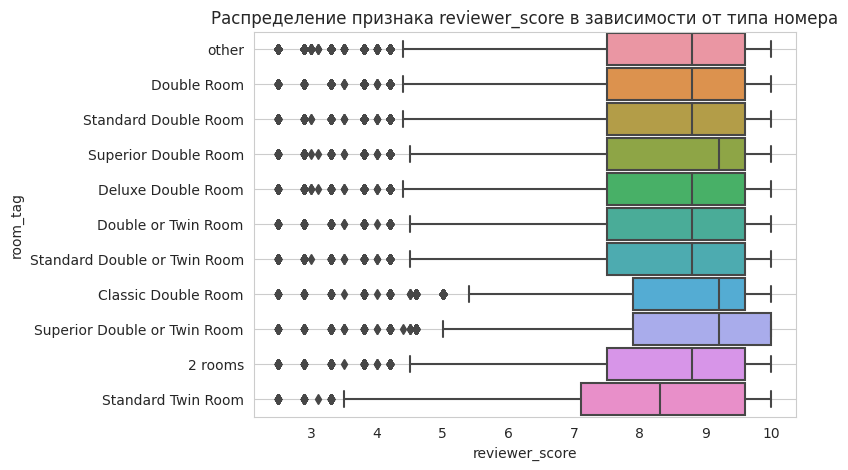

In [124]:
# Добавляем "other" (теперь самое популярное значение) в начало списка типов номеров
popular_room_tags_list = ['other'] + popular_room_tags_list 
fig_6 = plt.figure(figsize=(7, 5))
boxplot = sns.boxplot(
    data=hotels,
    y='room_tag',
    x='reviewer_score',
    order = popular_room_tags_list,
    orient='h',
    width=0.9)
boxplot.set_title('Распределение признака reviewer_score в зависимости от типа номера');
boxplot.set_xlabel('reviewer_score');
boxplot.set_ylabel('room_tag');
boxplot.grid()

Для многих типов номеров распределения оценок пользователей очень близки (например, Double Room, Standard Double Room и Deluxe Double Room), но есть и такие типы, распределения оценок которых несколько отличаются от других.

In [125]:
# Сначала задаем encoder, чтобы можно было далее применить его к X_val
room_tag_encoder = ce.OneHotEncoder(cols=['room_tag'], use_cat_names=True, return_df = True ).fit(hotels['room_tag']) 

# Функция одинарного кодирования room_tag
def room_type_encoder(df):
    df_room_tag = room_tag_encoder.transform(df['room_tag'])
    df = pd.concat([df, df_room_tag], axis=1)
    return df

hotels = room_type_encoder(hotels)

## Работаем с признаками negative_review и positive_review
#### (функции *review_changes_1*, *define_negative_review_weight*, *define_negative_review_weight*, *define_negative_review_weight*, *define_negatives*, *define_positives*)

In [126]:
negative_counts = hotels['negative_review'].value_counts().reset_index()
negative_counts  

,negative_review,count
0,No Negative,95833
1,Nothing,10733
2,Nothing,3152
3,nothing,1658
4,N A,802
...,...,...
248823,The room was extremely hot and stuffy The fan...,1
248824,Room size is quite compact,1
248825,The house keeping didn t clean the room for 2...,1
248826,On this occasion nothing,1


In [127]:
positive_counts = hotels['positive_review'].value_counts().reset_index()
positive_counts  

,positive_review,count
0,No Positive,26863
1,Location,6824
2,Everything,1697
3,location,1248
4,Nothing,930
...,...,...
311732,Clean well decorated,1
311733,Mushrooms st breakfast were great,1
311734,Giant bed friendly staff top location and ton...,1
311735,Everything was perfect from front desk staff ...,1


Видим, что формулировки не являются "стандартными": присутствует большое количество различных формулировок  (248828 отрицательных и 311737 положительных). \
Сначала приведем формулировки к более однообразному виду, затем создадим новые признаки. 

Основная функция преобразования текстов отзывов - *review_changes_1*, в ней выполняются следующие действия:
 - По краям некоторых отзывов могут быть "ненужные" пробелы (а могут и не быть). Сначала удалим все пробелы по краям отзывов, затем добавим по одному пробелу в начале и в конце отзыва, это упростит выполнение замен одних слов на другие (несколько первых или последних букв длинного слова нельзя будет принять за отдельное слово);
 - Текст преобразуется в нижний регистр;
 - Удаляются часто употребляемые слова, "не несущие смысловой нагрузки" (артикли, местоимения, многие предлоги, числительные);
 -  Часто употребляемые существительные во множественном числе заменяются единственным числом;
 - Обнаруженные в процессе анализа текстов опечатки исправляются;
 - Различные конструкции, несущие смысл отрицания (например, *no*, *not*, *didn t*, *cannot* и т.п.) заменяются на *no_*, "присоединяясь", таким образом, к следующему за ними слову;
 - Некоторые популярные короткие отзывы, несущие смысл "ничего", полностью заменяются на *nothing*.

In [128]:
# Функции для редактирования negative_review и positive_review
# Данные функции дополнялись в процессе анализа формулировок

popular_words = [' a ', ' the ', ' an ', 
                 ' to ', ' of ', ' for ', ' on ', ' at ',  ' with ', 
                 ' from ', ' up ', ' by ',
                 ' i ', ' you ', ' we ', ' he ', ' she ', ' they ', ' it ',
                 ' my ', ' our ', ' your ', ' his ', ' her ', ' its ',
                 ' this ', ' that ', ' these ', ' those ', ' which ',
                 ' are ', ' was ', ' were ', ' am ', ' is ', ' be ', ' s ', ' m ', ' re ',
                 ' me ', ' them ', ' us ', ' him ']

digit_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

# Функция удаления "несмысловых" слов
def delete_words(review):
    review = review.replace(' n a ', ' na ')
    review = review.replace(' a c ', ' ac ')
    for word in popular_words:
        review = review.replace(word, ' ')
    for dig in digit_list:
        review = review.replace(dig, '')
    review = review.replace('  ', ' ')    
    return review    
    
plurals_list = ['guests ', 'hotels ',  'windows ','times ', 'drinks ', 'things ',
                'walls ', 'days ', 'doors ', 'nights ', 'eggs ', 'hours ', 'lifts ',
                'options ', 'lights ','bags ', 'restaurants ', 'corridors ', 'curtains ', 
                'channels ', 'items ', 'issues ', 'pictures ', 'places ','tables ', 
                'areas ', 'carpets ', 'rooms ', 'breakfasts ', 'pillows ', 'beds ', 
                'comments ', 'experiences ', 'faults ', 'problems ', 'criticisms ',
                'towels ', 'bathrooms ', 'works ', 'minutes ', 'sheets ', 'floors ',
                'customers ', 'services ', 'cups ', 'others ', 'kids ', 'photos ', 
                'stains ','elevators ', 'friends ', 'details ', 'neighbors ', 'bedrooms ',
                'choices ', 'bathrobes ', 'bathrooms ', ' complains ', ' complaints ',
                'bottles ', 'standards ', 'bars ', 'plates ',  'chairs ', 'cleaners ',
                'sockets ', 'tiles ', 'steps ', 'views ', 'noises ', 'suitcases ', 'keys ',
                'years ', 'members ', 'mins ', 'stars ', 'showers ', 'cards ', 'ages ', 'toilets ',
                'points ', 'mornings ', 'meals ', 'hallways ', 'sausages ', 'snacks ', 
                'trains ', 'euros ', 'shops ', 'marks ']

replace_dict = {' check in ':' check_in ', ' check out ':' check_out ',' checkin ':' check_in ',
                ' checkout ':' check_out ', ' any thing ':' anything ', 'centre':'center',
                ' city center ':' city_center ', ' citycenter ':' city_center ', ' centrum ': ' center ',
                ' complaint ':' complain ', ' bath room ':' bathroom ', ' stuff ':' staff ',
                ' house keep':' housekeep', ' confort':' comfort',' excelen':' excellen',
                ' okay ':' ok ', ' wf ':' wifi ', ' wi fi ':' wifi ', ' wfi ': ' wifi ',
                ' realy ':' really ',' disappointinglying ':' disappointing lying ', 
                ' veiw ':' view ',' neighbour ':' neighbor ', ' hair dryer ':' hairdryer ',
                ' resturant ':' restaurant ', ' servise ':' service ', ' ambian':' ambien',
                ' absolutly ':' absolutely ', ' personel ':' personnel ',
                ' priceddisappointing ':' price disappointing ', 
                ' nothingseccess':'nothing success', 'nothinghotel':'nothing hotel',
                ' nothinggreat ': ' nothing great ', ' nothingperfect ':' nothing perfect ',
                ' nothingreally ':' nothing really ', ' wv ': ' wc ', ' complaint ': ' complain ',
                ' conceirge ': ' concierge ', ' staf ': ' staff '} 
   
# Функция замены множественного числа на единственное для популярных слов 
def plural_to_singular(x):
    for word in plurals_list:
        x = x.replace(word, word[:-2]+' ')
    #review = review.replace('complains', 'complain')
    x = x.replace('honestly', 'honest') 
    x = x.replace(' noisy ', ' noise ')
    x = x.replace(' mattresses ', ' mattress ')
    return x  

# Формируем списки для обнаруженных опечаток в популярных словах
everything_typo_list = [' every thing ', ' everithing ', ' evrything ', ' every think ',
                        ' eveything ', ' everthing ', ' everythin ',' everyhing ',
                        ' everythink ', ' everyrhing ', ' evry thing ']

nothing_typo_list = [' no_thing ', ' nothinh ', ' notting ', ' norhing ', ' nithing ', 
                     ' nathing ', ' nothink ', ' nothings ', ' nohing ', ' notthing ', 
                     ' nothng ', ' mothing ', ' nothimg ', ' not thing ', ' nothibg ', 
                     ' nuthing ', ' noting ',  ' noth ng ', ' nthing ', ' notjing ', 
                     ' northing ', ' nothig ', ' nothin ',  ' nihil ', ' notning ']

breakfast_typo_list = [' break fast ', ' breakfest ', ' breakfeast ', ' braekfast ']

location_typo_list = ['lication', 'lovation', 'lacation', 'lacstion', 'loction',  'locarion',
                     'locstion']

# Формируем списки для замен
couldn_t_typo_list = [' could not ', ' couldn t ',  ' cannot ', ' can not ', ' couldnot ',
                        ' can t ', ' couldnt ', ' cant ',
                        ' would not ', ' wouldn t ', ' wouldnt ', ' wouldnot ',
                        ' shouldn t ', ' should not ',' shouldnt ', ' shouldnot ']

didnt_isnt_typo_list  = [' didnt ', ' didn t ', ' did not ', ' doesn t ', ' don t ', 
                         ' wasn t ', ' weren t ',  ' aren t ', ' isn t ', ' ain t ',
                         ' won t ', ' isnt ', ' doesnt ', ' dont ', ' didnot ', ' ididnot ',
                         ' wasnt ', ' werent ',  ' arent ', ' aint ',
                         ' wont ', ' arenot ', ' isnot ', ' t ']

havent_typo_list = [' haven t ', ' hadn t ', ' hasn t ', ' havent ', ' hadnt ', ' hasnt ',
                    ' have not ', ' has not ', ' had not ', ' havenot ', ' hasnot ', ' hadnot ',
                    ' have not got ', ' has not got ', ' had not got ', ' havenot got ', ' hasnot got ', ' hadnot got ',
                    ' haven t got ', ' hadn t got ', ' hasn t got ']

# Cписок из отзывов целиком, которые заменим на ' nothing '
negative_list = [' nope ', ' no_negative ', ' n ', ' none ', ' _ ', '  ', ' ',
                 ' nil ', ' na ', ' no_', ' non ', ' nada ', ' zero ', ' nothin ', ' niks ',
                 ' rien ',  ' nowt ', ' x ', ' niets ', ' no_think ', ' ntg ', ' ni ', ' ntr ',
                 ' nulla ', ' nvt ',  ' nothing d ', ' nothing x ']

# Функция исправления обнаруженных опечаток
def typo_correction(x):
    x = re.sub('(\s\S*)breakf(\S*\s)', ' breakfast ',x)   
    x = re.sub('(\s\S*)bathro([^b]\S*\s)', ' bathroom ',x)   
    x = re.sub('(\s\S*)sappo(\S*\s)', ' disappoint ',x)  
    x = re.sub('(\s\S*)rythi(\S*\s)', ' everything ',x) 
    x = re.sub('(\s\S*)nothin(\S*\s)', ' nothing ',x)
    x = re.sub('(\s\S*)expens(\S*\s)', ' expensive ',x)
    
    for typo in everything_typo_list:
        x = x.replace(typo, ' everything ')                        
    
    for typo in nothing_typo_list:
        x = x.replace(typo, ' nothing ') 
        
    for typo in breakfast_typo_list:
        x = x.replace(typo, ' breakfast ')
    
    for typo in location_typo_list:
        x = x.replace(typo, 'location')
    
    for word in [' in ', ' out ',' had ', ' has ', ' having ', ' did ', ' does ', ' doing ', ' will ', ' shall ', ' would ', ' have ', ' do ']:
        x = x.replace(word, ' ')
        
    for word in replace_dict:
        x = x.replace(word, replace_dict[word])
        
    for typo in couldn_t_typo_list:
        x = x.replace(typo, ' no_')
    
    for typo in didnt_isnt_typo_list:
        x = x.replace(typo, ' no_')
    
    for typo in havent_typo_list:
        x = x.replace(typo, ' no_')    
    
 # 'Приклеиваем' частицу no к словам, к которым она (с большой вероятностью) относится
    x = x.replace(' no ', ' no_')
    x = x.replace(' not ', ' no_')    
    x = x.replace('no_no_', 'no_') 
    if x in negative_list:  # заменяем отзыв полностью
        x =  ' nothing '  
    x = x.replace('  ', ' ')    
    return x

# Функция для применения введенных выше функций к столбцам датасета
def review_changes_1(df):
# Избавимся от пробелов по краям отзывов, затем добавим ровно по одному пробелу в начале и в конце отзывов 
    df['negative_review'] = df['negative_review'].apply(lambda x: ' '+x.strip().lower()+' ')
    df['positive_review'] = df['positive_review'].apply(lambda x: ' '+x.strip().lower()+' ')
  
 # Создадим дублирующие столбцы (они пригодятся при пересчете длины отзыва)
#     df['negative_review_2'] = df['negative_review'].apply(lambda x: x.strip())
#     df['positive_review_2'] = df['positive_review'].apply(lambda x: x.strip())
 
# Удаляем артикли, предлоги, местоимения
    df['negative_review'] = df['negative_review'].apply(delete_words)
    df['positive_review'] = df['positive_review'].apply(delete_words)
# Заменим для популярных слов множественное число единственным
    df['negative_review'] = df['negative_review'].apply(plural_to_singular)
    df['positive_review'] = df['positive_review'].apply(plural_to_singular)    
# Исправим выявленные опечатки
    df['negative_review'] = df['negative_review'].apply(typo_correction)
    df['positive_review'] = df['positive_review'].apply(typo_correction)   
    return df    

In [129]:
# Применяем к датасету функцию review_changes_1
hotels = review_changes_1(hotels)

На данном этапе работы с *negative_review* и *positive_review* cоздаем признаки, характеризующие "вес" текста отзывов по отношению к *reviewer_score*.

В ячейке ниже создадим вспомогательный датасет *negative_words*, содержащий следующие столбцы:
 - *average_score*;
 - *reviewer_score*;
 - *delta* = *reviewer_score* - *average_score*;
 - *negative_review_list* - список слов из текста (строки) *negative_review*;
 - *negative_review_len* - количество слов в *negative_review*;
 - *delta_part* - средний "вклад" одного слова в *delta*;
 - *score_part* - средний "вклад" одного слова в *reviewer_score*.

In [130]:
negative_words = hotels[['negative_review','average_score','reviewer_score']]
negative_words['negative_review_list'] = negative_words['negative_review'].apply(lambda x: x.split())
negative_words['delta'] = negative_words['reviewer_score'] - negative_words['average_score']
negative_words['negative_review_len'] = negative_words['negative_review_list'].str.len()

# Оставляем только непустые отзывы
negative_words = negative_words[negative_words['negative_review_len'] > 0]
negative_words = negative_words.drop(['negative_review'], axis = 1) 

negative_words['delta_part'] = negative_words['delta']/negative_words['negative_review_len']
negative_words['score_part'] = negative_words['reviewer_score']/negative_words['negative_review_len']
negative_words

,average_score,reviewer_score,negative_review_list,delta,negative_review_len,delta_part,score_part
0,8.4,10.0,[leaving],1.6,1,1.600000,10.000000
1,8.3,6.3,"[poor, breakfast]",-2.0,2,-1.000000,3.150000
2,8.9,7.5,"[no_kettle, room]",-1.4,2,-0.700000,3.750000
3,7.5,10.0,[nothing],2.5,1,2.500000,10.000000
4,8.5,9.6,"[torn, sheet]",1.1,2,0.550000,4.800000
...,...,...,...,...,...,...,...
386491,9.0,8.8,[nothing],-0.2,1,-0.200000,8.800000
386492,8.4,9.2,[nothing],0.8,1,0.800000,9.200000
386493,6.8,8.3,"[room, really, small, but, guess, normal, london]",1.5,7,0.214286,1.185714
386494,8.1,9.2,[nothing],1.1,1,1.100000,9.200000


"Развернем" датасет по словам, содержащимся в отзыве

In [131]:
negative_words = negative_words.explode('negative_review_list')
negative_words = negative_words.rename(columns={'negative_review_list': 'negative_word'})
negative_words

,average_score,reviewer_score,negative_word,delta,negative_review_len,delta_part,score_part
0,8.4,10.0,leaving,1.6,1,1.600000,10.000000
1,8.3,6.3,poor,-2.0,2,-1.000000,3.150000
1,8.3,6.3,breakfast,-2.0,2,-1.000000,3.150000
2,8.9,7.5,no_kettle,-1.4,2,-0.700000,3.750000
2,8.9,7.5,room,-1.4,2,-0.700000,3.750000
...,...,...,...,...,...,...,...
386495,9.0,8.8,more,-0.2,12,-0.016667,0.733333
386495,9.0,8.8,uplifting,-0.2,12,-0.016667,0.733333
386495,9.0,8.8,atmosphere,-0.2,12,-0.016667,0.733333
386495,9.0,8.8,downstairs,-0.2,12,-0.016667,0.733333


Получили датасет *negative_words* со всеми словами из скорректированных *negative_review* и оценкой их вклада в *delta* и *reviewer_score*. \
В датасете более 4.1 млн. строк.

Далее выполним группировку по значениям признака *negative_word*.\
Для каждого слова по всем отзывам, где оно присутствует, будут рассчитаны следующие величины:
 - *review_count* - количество негативных отзывов, в которых упоминается слово;
 - *delta_mean* - среднее значение *delta* по отзывам, содержащим слово;
 - *score_mean* - среднее значение *reviewer_score* по отзывам, содержащим слово;
 - *delta_part_mean* - средний "вклад" слова в *delta*;
 - *score_part_mean* - средний "вклад" слова в *reviever_score*.
 

In [132]:
negative_words = negative_words.groupby('negative_word').agg(
    review_count=('delta', 'count'),
    delta_mean = ('delta', 'mean'),
    score_mean =('reviewer_score', 'mean'),
    delta_part_mean=('delta_part', 'mean'),
    score_part_mean=('score_part', 'mean')                                                
    ).sort_values(by='review_count', ascending=False).reset_index()

negative_words

,negative_word,review_count,delta_mean,score_mean,delta_part_mean,score_part_mean
0,and,163897,-1.162654,7.096410,-0.036782,0.377411
1,room,156007,-1.060363,7.183246,-0.048444,0.646029
2,nothing,129206,0.785588,9.314838,0.779886,8.649863
3,hotel,59250,-1.225111,7.052000,-0.037365,0.430754
4,but,56539,-0.425551,7.917055,0.005683,0.485717
...,...,...,...,...,...,...
50927,magnetised,1,-0.700000,7.500000,-0.018421,0.197368
50928,magn,1,0.500000,9.200000,0.035714,0.657143
50929,magica,1,0.800000,9.200000,0.036364,0.418182
50930,maghogany,1,-0.400000,6.300000,-0.014815,0.233333


Получили характеристики для каждого слова.\
Задаем функцию создания 16 новых *negative*-признаков - совокупных характеристик текста *negative_review*,  которые получены применением агрегатных функций к характеристикам всех слов, содержащихся в тексте отзыва:
 - *neg_delta_mean_mean*
 - *neg_delta_mean_max* 
 - *neg_delta_mean_min*
 - *neg_delta_mean_sum*  
 - *neg_score_mean_mean* 
 - *neg_score_mean_max* 
 - *neg_score_mean_min*
 - *neg_score_mean_sum* 
 - *neg_delta_part_mean_mean*
 - *neg_delta_part_mean_max* 
 - *neg_delta_part_mean_min* 
 - *neg_delta_part_mean_sum* 
 - *neg_score_part_mean_mean* 
 - *neg_score_part_mean_max* 
 - *neg_score_part_mean_min* 
 - *neg_score_part_mean_sum*

In [133]:
# Отбрасываем слова, используемые менее 5 раз
# Эта величина (5) может быть изменена по результатам обучения модели
negative_words = negative_words[negative_words['review_count'] >= 5]

# Вычисляем средние значения delta_mean, score_mean, delta_part_mean и score_part_mean  
# по всему датасету для последующего заполнения пропусков
mean_neg_delta_mean = negative_words['delta_mean'].mean()
mean_neg_score_mean = negative_words['score_mean'].mean()
mean_neg_delta_part_mean = negative_words['delta_part_mean'].mean()
mean_neg_score_part_mean = negative_words['score_part_mean'].mean()

# Функция, считающая совокупное влияние всех слов отзыва на оценку пользователя
def define_negative_review_weight(df):
    # Cоздаем датасет с неповторяющимися negative_review
    df_nr = df[['negative_review']].drop_duplicates()
    # Превращаем в столбце negative_review строку в список слов
    df_nr['negative_review_list'] = df_nr['negative_review'].apply(lambda x: x.split())
    # "Развернем" датасет по словам, содержащимся в отзыве
    df_nr = df_nr.explode('negative_review_list').reset_index()
    df_nr = df_nr.rename(columns={'negative_review_list': 'negative_word'})
    # Объединяем df_nr c negative_words по столбцу negative_word
    df_nr = df_nr.merge(negative_words, on = 'negative_word', how='left').reset_index()
    # Заполняем пропуски
    df_nr['delta_mean']=df_nr['delta_mean'].fillna(mean_neg_delta_mean)
    df_nr['score_mean']=df_nr['score_mean'].fillna(mean_neg_score_mean)
    df_nr['delta_part_mean']=df_nr['delta_part_mean'].fillna(mean_neg_delta_part_mean)
    df_nr['score_part_mean']=df_nr['score_part_mean'].fillna(mean_neg_score_part_mean)
    # Выполняем группировку по столбцу negative_review, создавая новые признаки
    df_nr = df_nr.groupby('negative_review').agg(
        neg_delta_mean_mean=("delta_mean", 'mean'),
        neg_delta_mean_max=("delta_mean", 'max'),
        neg_delta_mean_min=("delta_mean", 'min'),
        neg_delta_mean_sum=("delta_mean", 'sum'),
        neg_score_mean_mean=("score_mean", 'mean'),
        neg_score_mean_max=("score_mean", 'max'),
        neg_score_mean_min=("score_mean", 'min'),
        neg_score_mean_sum=("score_mean", 'sum'),
        neg_delta_part_mean_mean=("delta_part_mean", 'mean'),
        neg_delta_part_mean_max=("delta_part_mean", 'max'),
        neg_delta_part_mean_min=("delta_part_mean", 'min'),
        neg_delta_part_mean_sum=("delta_part_mean", 'sum'),
        neg_score_part_mean_mean=("score_part_mean", 'mean'),
        neg_score_part_mean_max=("score_part_mean", 'max'),
        neg_score_part_mean_min=("score_part_mean", 'min'),
        neg_score_part_mean_sum=("score_part_mean", 'sum')
        )
    # Объединяем df c df_nr по столбцу negative_review
    df = df.merge(df_nr,on = 'negative_review')
    return df

hotels = define_negative_review_weight(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,native_hotel,nationality_score,hotel_popularity,submitted_from_a_mobile_device,stayed_nights,leisure_trip,business_trip,couple,solo_traveler,family_with_young_children,group,with_a_pet,family_with_older_children,travelers_with_friends,room_tag,room_tag_delta_mean,room_tag_score_mean,room_tag_other,room_tag_Standard Double Room,room_tag_Standard Double or Twin Room,room_tag_Superior Double Room,room_tag_Double Room,room_tag_Double or Twin Room,room_tag_2 rooms,room_tag_Classic Double Room,room_tag_Standard Twin Room,room_tag_Deluxe Double Room,room_tag_Superior Double or Twin Room,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum
0,581,8.4,The May Fair Hotel,United Kingdom,leaving,3,1994,staff amazing,4,7,10.0,531,1,0,0,0,0,0,1,8.488676,2575,1,2.0,1,0,1,0,0,0,0,0,0,other,0.115285,9.046041,1,0,0,0,0,0,0,0,0,0,0,-0.673559,-0.673559,-0.673559,-0.673559,7.737881,7.737881,7.737881,7.737881,0.160235,0.160235,0.160235,0.160235,1.900479,1.900479,1.900479,1.900479
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,203,1,0,0,0,0,0,1,8.488676,1660,0,1.0,0,1,1,0,0,0,0,0,0,Standard Double Room,0.011470,8.256530,0,1,0,0,0,0,0,0,0,0,0,-1.004827,-0.514008,-1.495646,-2.009654,7.283166,7.838600,6.727732,14.566332,-0.053873,-0.008976,-0.098771,-0.107747,0.830313,0.947872,0.712755,1.660626


In [134]:
# # инициализируем нормализатор RobustScaler
# r_scaler = preprocessing.StandardScaler()

# # кодируем исходный датасет
# df_r = r_scaler.fit_transform(hotels[['neg_delta_mean_mean',  'neg_delta_mean_max',  'neg_delta_mean_min', 'neg_delta_mean_sum']])

# # Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
# df_r = pd.DataFrame(df_r, columns=['neg_delta_mean_mean',  'neg_delta_mean_max',  'neg_delta_mean_min', 'neg_delta_mean_sum'])

# fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
# ax1.set_title('Распределения после RobustScaler')

# sns.kdeplot(df_r['neg_delta_mean_mean'], ax=ax1)
# sns.kdeplot(df_r['neg_delta_mean_max'], ax=ax1)
# sns.kdeplot(df_r['neg_delta_mean_min'], ax=ax1)
# sns.kdeplot(df_r['neg_delta_mean_sum'], ax=ax1)

Аналогичным образом создадим 16 *positive*-признаков для *positive_review*.

In [135]:
positive_words = hotels[['positive_review','average_score','reviewer_score']]
positive_words['positive_review_list'] = positive_words['positive_review'].apply(lambda x: x.split())
positive_words['positive_review_len'] = positive_words['positive_review_list'].str.len()
positive_words=positive_words[positive_words['positive_review_len'] > 0]
positive_words = positive_words.drop(['positive_review'], axis = 1)
positive_words['delta'] = positive_words['reviewer_score'] - positive_words['average_score']
positive_words['delta_part'] = (positive_words['reviewer_score'] - positive_words['average_score'])/positive_words['positive_review_len']
positive_words['score_part'] = positive_words['reviewer_score']/positive_words['positive_review_len']

# "Развернем" датасет по словам, содержащимся в отзыве
positive_words = positive_words.explode('positive_review_list')
positive_words = positive_words.rename(columns={'positive_review_list': 'positive_word'})
positive_words

# Группировка по признаку positive_word
positive_words = positive_words.groupby('positive_word').agg(
    delta_mean=('delta', 'mean'),
    review_count=('delta', 'count'),
    score_mean=('reviewer_score', 'mean'),
    delta_part_mean=('delta_part', 'mean'),
    score_part_mean=('score_part', 'mean')
    ).sort_values(by='review_count', ascending=False).reset_index() 

# Отбрасываем слова, используемые менее 5 раз
positive_words = positive_words[positive_words['review_count']>=5]
# Заполняем пропуски
mean_pos_delta_mean = positive_words['delta_mean'].mean()
mean_pos_score_mean = positive_words['score_mean'].mean()
mean_pos_delta_part_mean = positive_words['delta_part_mean'].mean()
mean_pos_score_part_mean = positive_words['score_part_mean'].mean()

# Функция, считающая совокупное влияние всех слов отзыва на оценку пользователя
def define_positive_review_weight(df):
    df_pr = df[['positive_review']].drop_duplicates()
    df_pr['positive_review_list'] = df_pr['positive_review'].apply(lambda x: x.split())
    df_pr = df_pr.explode('positive_review_list').reset_index()
    df_pr = df_pr.rename(columns={'positive_review_list': 'positive_word'})
    df_pr = df_pr.merge(positive_words, on = 'positive_word', how='left').reset_index()
    df_pr['delta_mean']=df_pr['delta_mean'].fillna(mean_pos_delta_mean)
    df_pr['score_mean']=df_pr['score_mean'].fillna(mean_pos_score_mean)
    df_pr['delta_part_mean']=df_pr['delta_part_mean'].fillna(mean_pos_delta_part_mean)
    df_pr['score_part_mean']=df_pr['score_part_mean'].fillna(mean_pos_score_part_mean)
    df_pr = df_pr.groupby('positive_review').agg(
        pos_delta_mean_mean=('delta_mean', 'mean'),
        pos_delta_mean_max=('delta_mean', 'max'),
        pos_delta_mean_min=('delta_mean', 'min'),
        pos_delta_mean_sum=('delta_mean', 'sum'),
        pos_score_mean_mean=('score_mean', 'mean'),
        pos_score_mean_max=('score_mean', 'max'),
        pos_score_mean_min=('score_mean', 'min'),
        pos_score_mean_sum=('score_mean', 'sum'),
        pos_delta_part_mean_mean=('delta_part_mean', 'mean'),
        pos_delta_part_mean_max=('delta_part_mean', 'max'),
        pos_delta_part_mean_min=('delta_part_mean', 'min'),
        pos_delta_part_mean_sum=('delta_part_mean', 'sum'),
        pos_score_part_mean_mean=('score_part_mean', 'mean'),
        pos_score_part_mean_max=('score_part_mean', 'max'),
        pos_score_part_mean_min=('score_part_mean', 'min'),
        pos_score_part_mean_sum=('score_part_mean', 'sum')
        )
    df = df.merge(df_pr,on = 'positive_review')
    return df

hotels=define_positive_review_weight(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,native_hotel,nationality_score,hotel_popularity,submitted_from_a_mobile_device,stayed_nights,leisure_trip,business_trip,couple,solo_traveler,family_with_young_children,group,with_a_pet,family_with_older_children,travelers_with_friends,room_tag,room_tag_delta_mean,room_tag_score_mean,room_tag_other,room_tag_Standard Double Room,room_tag_Standard Double or Twin Room,room_tag_Superior Double Room,room_tag_Double Room,room_tag_Double or Twin Room,room_tag_2 rooms,room_tag_Classic Double Room,room_tag_Standard Twin Room,room_tag_Deluxe Double Room,room_tag_Superior Double or Twin Room,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum,pos_delta_mean_mean,pos_delta_mean_max,pos_delta_mean_min,pos_delta_mean_sum,pos_score_mean_mean,pos_score_mean_max,pos_score_mean_min,pos_score_mean_sum,pos_delta_part_mean_mean,pos_delta_part_mean_max,pos_delta_part_mean_min,pos_delta_part_mean_sum,pos_score_part_mean_mean,pos_score_part_mean_max,pos_score_part_mean_min,pos_score_part_mean_sum
0,581,8.4,The May Fair Hotel,United Kingdom,leaving,3,1994,staff amazing,4,7,10.0,531,1,0,0,0,0,0,1,8.488676,2575,1,2.0,1,0,1,0,0,0,0,0,0,other,0.115285,9.046041,1,0,0,0,0,0,0,0,0,0,0,-0.673559,-0.673559,-0.673559,-0.673559,7.737881,7.737881,7.737881,7.737881,0.160235,0.160235,0.160235,0.160235,1.900479,1.900479,1.900479,1.900479,0.606288,0.748134,0.464442,1.212576,9.167293,9.390363,8.944223,18.334586,0.049638,0.070621,0.028655,0.099276,0.988980,0.997587,0.980374,1.977961
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,203,1,0,0,0,0,0,1,8.488676,1660,0,1.0,0,1,1,0,0,0,0,0,0,Standard Double Room,0.011470,8.256530,0,1,0,0,0,0,0,0,0,0,0,-1.004827,-0.514008,-1.495646,-2.009654,7.283166,7.838600,6.727732,14.566332,-0.053873,-0.008976,-0.098771,-0.107747,0.830313,0.947872,0.712755,1.660626,0.035458,0.035458,0.035458,0.035458,8.426522,8.426522,8.426522,8.426522,-0.119745,-0.119745,-0.119745,-0.119745,1.585845,1.585845,1.585845,1.585845


Объединим тексты *positive_review* и *negative_review* и создадим аналогичные признаки для "вклада" слов "совокупного" отзыва в *reviewer_score*.
Новые признаки будут называться *rew_delta_mean_mean*, *rew_delta_mean_max* и т.п.

In [136]:
words = hotels[['positive_review','average_score','reviewer_score','negative_review']]
words['review']=words['positive_review']+words['negative_review']
words['review_list'] = words['review'].apply(lambda x: x.split())
words['review_len'] = words['review_list'].str.len()
words=words[words['review_len'] > 0]
words = words.drop(['positive_review','negative_review','review'], axis = 1)
words['delta'] = words['reviewer_score'] - words['average_score']
words['delta_part'] = (words['reviewer_score'] - words['average_score'])/words['review_len']
words['score_part'] = words['reviewer_score']/words['review_len']

# "Развернем" датасет по словам, содержащимся в отзыве
words = words.explode('review_list')
words = words.rename(columns={'review_list': 'word'})
words

# Группировка по признаку word
words = words.groupby('word').agg(
    delta_mean=('delta', 'mean'),
    review_count=('delta', 'count'),
    score_mean=('reviewer_score', 'mean'),
    delta_part_mean=('delta_part', 'mean'),
    score_part_mean=('score_part', 'mean')
    ).sort_values(by='review_count', ascending=False).reset_index() 

# Отбрасываем слова, используемые менее 5 раз
words = words[words['review_count']>=5]
# Заполняем пропуски
mean_rew_delta_mean = words['delta_mean'].mean()
mean_rew_score_mean = words['score_mean'].mean()
mean_rew_delta_part_mean = words['delta_part_mean'].mean()
mean_rew_score_part_mean = words['score_part_mean'].mean()

# Функция, считающая совокупное влияние всех слов отзыва на оценку пользователя
def define_review_weight(df):
    df['review']=df['positive_review']+df['negative_review']
    df_r = df[['review']].drop_duplicates()
    df_r['review_list'] = df_r['review'].apply(lambda x: x.split())
    df_r = df_r.explode('review_list').reset_index()
    df_r = df_r.rename(columns={'review_list': 'word'})
    df_r = df_r.merge(words, on = 'word', how='left').reset_index()
    df_r['delta_mean']=df_r['delta_mean'].fillna(mean_rew_delta_mean)
    df_r['score_mean']=df_r['score_mean'].fillna(mean_rew_score_mean)
    df_r['delta_part_mean']=df_r['delta_part_mean'].fillna(mean_rew_delta_part_mean)
    df_r['score_part_mean']=df_r['score_part_mean'].fillna(mean_rew_score_part_mean)
    df_r = df_r.groupby('review').agg(
        rew_delta_mean_mean=('delta_mean', 'mean'),
        rew_delta_mean_max=('delta_mean', 'max'),
        rew_delta_mean_min=('delta_mean', 'min'),
        rew_delta_mean_sum=('delta_mean', 'sum'),
        rew_score_mean_mean=('score_mean', 'mean'),
        rew_score_mean_max=('score_mean', 'max'),
        rew_score_mean_min=('score_mean', 'min'),
        rew_score_mean_sum=('score_mean', 'sum'),
        rew_delta_part_mean_mean=('delta_part_mean', 'mean'),
        rew_delta_part_mean_max=('delta_part_mean', 'max'),
        rew_delta_part_mean_min=('delta_part_mean', 'min'),
        rew_delta_part_mean_sum=('delta_part_mean', 'sum'),
        rew_score_part_mean_mean=('score_part_mean', 'mean'),
        rew_score_part_mean_max=('score_part_mean', 'max'),
        rew_score_part_mean_min=('score_part_mean', 'min'),
        rew_score_part_mean_sum=('score_part_mean', 'sum')
        )
    df = df.merge(df_r,on = 'review')
    df = df.drop(['review'], axis = 1)
    return df

hotels=define_review_weight(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,native_hotel,nationality_score,hotel_popularity,submitted_from_a_mobile_device,stayed_nights,leisure_trip,business_trip,couple,solo_traveler,family_with_young_children,group,with_a_pet,family_with_older_children,travelers_with_friends,room_tag,room_tag_delta_mean,room_tag_score_mean,room_tag_other,room_tag_Standard Double Room,room_tag_Standard Double or Twin Room,room_tag_Superior Double Room,room_tag_Double Room,room_tag_Double or Twin Room,room_tag_2 rooms,room_tag_Classic Double Room,room_tag_Standard Twin Room,room_tag_Deluxe Double Room,room_tag_Superior Double or Twin Room,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum,pos_delta_mean_mean,pos_delta_mean_max,pos_delta_mean_min,pos_delta_mean_sum,pos_score_mean_mean,pos_score_mean_max,pos_score_mean_min,pos_score_mean_sum,pos_delta_part_mean_mean,pos_delta_part_mean_max,pos_delta_part_mean_min,pos_delta_part_mean_sum,pos_score_part_mean_mean,pos_score_part_mean_max,pos_score_part_mean_min,pos_score_part_mean_sum,rew_delta_mean_mean,rew_delta_mean_max,rew_delta_mean_min,rew_delta_mean_sum,rew_score_mean_mean,rew_score_mean_max,rew_score_mean_min,rew_score_mean_sum,rew_delta_part_mean_mean,rew_delta_part_mean_max,rew_delta_part_mean_min,rew_delta_part_mean_sum,rew_score_part_mean_mean,rew_score_part_mean_max,rew_score_part_mean_min,rew_score_part_mean_sum
0,581,8.4,The May Fair Hotel,United Kingdom,leaving,3,1994,staff amazing,4,7,10.0,531,1,0,0,0,0,0,1,8.488676,2575,1,2.0,1,0,1,0,0,0,0,0,0,other,0.115285,9.046041,1,0,0,0,0,0,0,0,0,0,0,-0.673559,-0.673559,-0.673559,-0.673559,7.737881,7.737881,7.737881,7.737881,0.160235,0.160235,0.160235,0.160235,1.900479,1.900479,1.900479,1.900479,0.606288,0.748134,0.464442,1.212576,9.167293,9.390363,8.944223,18.334586,0.049638,0.070621,0.028655,0.099276,0.988980,0.997587,0.980374,1.977961,0.107567,0.719692,-0.531192,0.322702,8.604200,9.357839,7.875911,25.812600,0.024070,0.054463,-0.001274,0.072211,0.505210,0.622816,0.33980,1.515629
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,203,1,0,0,0,0,0,1,8.488676,1660,0,1.0,0,1,1,0,0,0,0,0,0,Standard Double Room,0.011470,8.256530,0,1,0,0,0,0,0,0,0,0,0,-1.004827,-0.514008,-1.495646,-2.009654,7.283166,7.838600,6.727732,14.566332,-0.053873,-0.008976,-0.098771,-0.107747,0.830313,0.947872,0.712755,1.660626,0.035458,0.035458,0.035458,0.035458,8.426522,8.426522,8.426522,8.426522,-0.119745,-0.119745,-0.119745,-0.119745,1.585845,1.585845,1.585845,1.585845,-0.520446,-0.010629,-1.516488,-1.561337,7.811337,8.374718,6.703869,23.434012,-0.022759,0.005778,-0.079199,-0.068276,0.544474,0.699085,0.41812,1.633422


Посмотрим на распределения новых признаков.

In [137]:
# word_features_list = [
#     'neg_delta_mean_mean',
#     'neg_delta_mean_max',
#     'neg_delta_mean_min',
#     'neg_delta_mean_sum',
#     'neg_score_mean_mean',
#     'neg_score_mean_max',
#     'neg_score_mean_min',
#     'neg_score_mean_sum',
#     'neg_delta_part_mean_mean',
#     'neg_delta_part_mean_max',
#     'neg_delta_part_mean_min',
#     'neg_delta_part_mean_sum',
#     'neg_score_part_mean_mean',
#     'neg_score_part_mean_max',
#     'neg_score_part_mean_min',
#     'neg_score_part_mean_sum'
# ]

# for feature in word_features_list:
#     fig_wf = plt.figure(figsize=(10, 0.5))
#     boxplot = sns.boxplot(
#         data = hotels,
#     #y='hotel_country',
#         x=feature,
#         orient='h',
#         width=0.9)
#    # boxplot.set_title('Распределение признака '+feature) #reviewer_score по странам расположения отелей');
#     #boxplot.set_xlabel('reviewer_score');
#     #boxplot.set_ylabel('hotel_country');
#     boxplot.grid()

#Видим, что к признакам pos_delta_part_mean, pos_delta_part_min, pos_delta_part_max, 
#pos_delta_part_sum целесообразнее применить нормализацию Robust_Scaler.

Созданы признаки, основанные на "положительном" или "отрицательном" весе одного (каждого) слова. Можно попробовать аналогичным образом рассмотреть все имеющиеся в отзывах комбинации из двух слов и построить числовые признаки на основе их "вклада" в *reviewer_score*.

Далее на основе *negative_review* и *positive_review* создадим *negative*- и *positive*-признаки, соответствующие конкретным положительным и отрицательным качествам отеля.

#### Работаем с признаком negative_review

In [138]:
#Посмотрим на наиболее популярные формулировки
negative_counts = hotels['negative_review'].value_counts().reset_index()
negative_counts.head(40)

,negative_review,count
0,nothing,115991
1,small room,670
2,all good,606
3,nothing really,499
4,breakfast,489
5,room very small,473
6,no_complain,465
7,location,452
8,everything,392
9,there nothing no_like,360


Видим, что во многих случаях отрицательный отзыв сводится к тому, что замечаний к отелю у пользователя нет. \
Потребуется создать признак negative_nothing, принимающий в описанных случаях значение 1, иначе - 0.\
На основе других популярных формулировок создадим другие negative-признаки, отражающие основные замечания к отелю.

In [139]:
# Посмотрим на очень короткие отзывы
negative_counts['str_len'] = negative_counts['negative_review'].apply(lambda x: len(x))
negative_counts_shorts = negative_counts[negative_counts['str_len'] <= 4].reset_index()
negative_counts_shorts 

,index,negative_review,count,str_len
0,343,ok,15,4
1,372,tv,14,4
2,477,ac,11,4
3,1039,o,6,3
4,1635,g,4,3
5,3240,v,2,3
6,3955,j,2,3
7,3984,z,2,3
8,4156,c,2,3
9,4389,l,2,3


Видим, что отзывы, состоящие из 0, 1 и 2 (за небольшим исключением) символов, можно отнести к новому признаку 'negative_nothing' (так как претензия к отелю в них не сформулирована). Суммарно таких отзывов очень небольшое количество.

В процессе анализа различных имеющихся формулировок наиболее популярные из них и соответствующие отсутствию негативного отзыва постепенно добавляются в список *nothing_negative_list* (который может "устаревать" при добавлении изменений в функцию *review_changes_1*).\
Также формируются списки формулировок:
- *bad_complectation_list* для нового признака *negative_complectation*, отражающего замечания к оснащению номеров;
- *bad_check_in_out_list* для нового признака *negative_check_in_out*;
- *bad_location_list* для нового признака *negative_location*;
- *everything_negative_list* формулировок того, что в отеле 'все плохо'; 
- other_negatives_list, в который попадают формулировки, не соответствующие другим созданным признакам. 

In [140]:
nothing_negative_list = [' absolutely no_complain ',' absolutely nothing complain about ',
 ' absolutely perfect ', ' actually nothing ', ' all good nothing complain about ',
 ' all right ', ' almost nothing ',' anything ',
 ' come home ',' coming home ', ' completely satisfied ',
 ' could stay longer ', ' could stayed longer ',
 ' enjoyed everything ',' everything exceeded expectations ', ' everything point ',
 ' everything top notch ',
 ' fact leave ',' fact no_stay longer ',' fact only stayed one night ',
 ' faultless ',' flawless ',' go home ', ' going home ',' great hotel ',
 ' happy all ',' happy everything ', ' happy stay ',
 ' hard find ',' honest nothing ',' honest there nothing no_like ',
 ' if could stayed longer ',' just right ',' keep good work ',
 ' leave ',' leave and go home ', ' leave come home ', ' leave hotel ', ' leave too soon ',
 ' leaving ', ' leaving go home ', ' leaving hotel ',' leaving so soon ',
 ' like all ',' like everything ', ' liked all ', ' liked everything ',
 ' liked everything about hotel ',' literally nothing ', ' longer stay ',
 ' love everything ', ' loved ',' loved all ',' loved hotel ',
 ' no_actually think anything ',' no_adverse comment ',' no_all ', ' no_answer ',
 ' no_any bad experience ',' no_any complain ', ' no_any complain all ', ' no_anything ',
 ' no_anything no_like ', ' no_applicable ', ' no_apply ', ' no_bad comment ',
 ' no_bad point ', ' no_bad thing say ', ' no_been any better ', ' no_been better ',
 ' no_being able stay longer ',' no_better ',
 ' no_change anything ', ' no_change thing ',' no_changed anything ',
 ' no_comment ',' no_comment all good ',' no_comment here ',' no_comment make ',
 ' no_concerns ', ' no_criticism ',' no_enough time ',' no_enough time there ',
 ' no_fault anything about hotel ',' no_find ',' no_find any fault ',
 ' no_find any fault hotel ',' no_find anything ',' no_find anything complain about ',
 ' no_find anything dislike ', ' no_find anything no_like ',' no_find anything wrong ',
 ' no_find fault ',' no_find fault anything ',' no_find single fault ',
 ' no_get stay longer ',' no_idea ', ' no_improve perfection ',' no_issue ',' no_issue all ',
 ' no_issue during stay ',' no_issue hotel ',' no_issue whatsoever ',' no_know ',
 ' no_like anything ',' no_like leave ',' no_like leaving ',' no_like nothing ',
 ' no_long enough stay ',' no_long enough there ',
 ' no_lot ', ' no_much ', ' no_much dislike ',' no_much no_like ',' no_much really ',
 ' no_much say here ',' no_name one thing ',' no_one ',' no_one complain ',' no_one thing ',
 ' no_particular ',' no_problem ',' no_problem all ',' no_real complain ',' no_real issue ',
 ' no_really ',' no_really complain about anything ',' no_really fault ',
 ' no_really fault anything ',' no_really find fault ',' no_really think anything ',
 ' no_remark ', ' no_say ',' no_say anything ',' no_say anything bad about hotel ',
 ' no_say there anything no_like ',' no_single complain ',' no_single thing ',
 ' no_stay any longer ',' no_stay long enough ',' no_stay longer ',' no_staying longer ',
 ' no_such thing ', ' no_suggestions ', ' no_sure ',' no_there long enough ',
 ' no_thing ',' no_thing all ', ' no_think any ',' no_think any negatives ',
 ' no_think if anything ',' no_think one ',' no_think one thing ',
 ' no_think single thing ',' no_think something no_like ',' no_think there anything no_like ',
 ' no_think thing ',' no_think thing no_like ',' no_want leave ',' non applicable ',
 ' none all ',' none can think ',' none mention ',' none really ',' none report ',
 ' none so far ', ' none whatsoever ',
 ' nothing ',' nothing actually ',' nothing add ',' nothing add here ',' nothing all ',
 ' nothing all complain about ',' nothing all dislike ',' nothing as far as concerned ',
 ' nothing as such ',' nothing can recall ',' nothing can remember ',' nothing can think ',
 ' nothing can think off ',' nothing comes mind ',' nothing comment ',
 ' nothing could been better ',' nothing could been improved ',
 ' nothing could been improved upon ',' nothing could better ',' nothing could fault ',
 ' nothing could faulted ',' nothing could improved ',' nothing could think ',
 ' nothing criticise ',' nothing declare ', ' nothing definitely stay again ',
 ' nothing else ',' nothing enjoyed all ',' nothing enjoyed stay ',
 ' nothing exceeded expectations ',' nothing fault ',' nothing highly recommended ',
 ' nothing honest ',' nothing important ',' nothing improve ',' nothing major ',
 ' nothing mention ',' nothing mention here ',' nothing mentioned ',' nothing moan about ',
 ' nothing much ',' nothing no_been better ',' nothing no_complain ',
 ' nothing no_complain all ',' nothing no_dislike ',' nothing no_fault ',
 ' nothing no_fault all ',' nothing no_fault anything ', ' nothing no_fault hotel ',
 ' nothing no_find fault ', ' nothing note ',' nothing noticed ',' nothing particular ',
 ' nothing particularly ', ' nothing point ',' nothing really ',
 ' nothing really complain about ',' nothing really enjoyed stay ',
 ' nothing really very happy ',' nothing report ',' nothing report here ',' nothing return ',
 ' nothing say ',' nothing say here ',' nothing serious ',' nothing significant ',
 ' nothing so far ',' nothing speak ',' nothing special ',' nothing special about ',
 ' nothing specific ',' nothing specifically ',' nothing spot ',' nothing springs mind ',
 ' nothing stands ',' nothing stay again ',' nothing tell ',' nothing think ',' nothing time ',
 ' nothing whatsoever ',' nothing worth mentioning ',' nothing write here ',' nothing wrong ',
 ' nothing wrong all ',' only no_stay longer ',' only one night ',
 ' only one night stay ',' only regret no_stay longer ',' only stayed night ',
 ' only stayed one night ',' only staying one night ',' only there night ',
 ' only there one night ',' perfect hotel ',' pleased everything ',' really no_complain ',
 ' really no_fault ',' really no_know ',' really no_think anything ',
 ' really no_think anything no_like ', ' really nothing ',' satisfied everything ',
 ' short stay ',' should stayed longer ',' so far nothing ',' stay could been longer ',
 ' stay no_long enough ',' stay short ',' stay too short ',' struggling think anything ',
 ' thank ',' there absolutely nothing dislike ',' there absolutely nothing no_like ',
 ' there absolutely nothing no_like about hotel ',' there no_anything ',
 ' there no_anything dislike ',' there no_anything disliked ',' there no_anything no_like ',
 ' there no_anything no_like about hotel ',' there no_issue ',' there no_one thing no_like ',
 ' there no_such thing ',' there no_thing no_like ',' there nothing ',
 ' there nothing about hotel no_like ',' there nothing all no_like ',' there nothing change ',
 ' there nothing complain ',' there nothing complain about ',' there nothing could fault ',
 ' there nothing fault ',' there really no_anything no_like ',' too short stay ',
 ' totally satisfied ',' very good ',' very happy ',' very happy everything ',' very nice ',
 ' wanted stay longer ',' what no_like ',' what there no_like ',' whats no_like ',
 ' wish could stayed longer ',' wish d stayed longer ',' wish stayed longer ',
 ' wished could stayed longer ', ' no_think anything no_like about hotel ',
 ' no_think anything could been better ',' no_think anything could been improved ',
 ' absolutely none ',' very thing good ',' no_improvement needed ',' no_easy find ',
 ' could only stay one night ',' no_thing no_like ',' nothing stayed before ',
 ' high rate ',' nothing worth every penny ',' no_stayed longer ',' nothing all as expected ',
 ' no_really dislike anything ',' leave go home ',' no_find anything bad ',
 ' nothing much liked everything ',' nothing really quite satisfied ',
 ' no_find anything wrong hotel ',' nothing can say ',' nothing significance ',
 ' nothing matters ',' liked everything hotel ',' nothing especially ',
 ' no_bad point all ',' generally satisfied ',' really nothing complain about ',
 ' how short stay ',' perfection ',' no_any better ',' nothing change ',
 ' pretty much nothing ',' no_much improve ',' nothing here ',' nothing all no_fault ',
 ' nothing around ',' nothing back ',' really no_any complain ',' no_found ',
 ' nothing relevant ',' no_any issue ']
 
bad_check_in_out_list = [ ' wait check long ',' check could been quicker ',
 ' check pm ',' check process ',' check time ', ' check took too long ',
 ' checking ',' late check ',' long wait check ',' no_early check ',' no_late check ', 
 ' pm check ', ' pm check ', ' wait check ', ' check could been faster ']

bad_location_list = [ ' bit way ',' far downtown ',  ' bit off beaten track ',  
                     ' difficult find ',  ' away city_center ', ' long walk tube station ',
                     ' no_much around hotel ']

bad_complectation_list = [' no_cons ', ' no_room safe ', ' bit dark ', ' no_heating ',
 ' creaky floorboards ',' furniture ', ' heating system ',' lighting ',' no_balcony ',
 ' no_bidet ',' no_complementary water ',' no_complimentary water ',' no_fridge ',
 ' fridge no_work ',' no_hot water ',' no_refrigerator ',' no_slippers ',' no_wardrobe ',
 ' safe no_work ',' safe no_working ',' there no_hot water morning ',' thin wall ',
 ' too dark ',' towel ',  ' paper thin wall ',' wall quite thin ',  ' lighting system ',
 ' water no_very hot ', ' no_complimentary bottle water '] 

everything_negative_list = [' all ', ' everything ', ' everything else ',  ' most thing ', 
 ' almost everything ', ' everything bad ',  ' hotel ',' no_good ', ' no_relevant ',  
 ' all hotel ', ' bad ',' everything could improved ', ' lot ', ' most ']

other_negatives_list = [ ' deposit ',' executive lounge ', ' hangover ', ' left ',
 ' no_business center ',' no_downside ',' quite ',' ras ',' rate ',' rest ',' same ',
 ' size ',' too big ',' very hot hotel ']

Ниже две вспомогательные ячейки для работы со списком nothing_negative_list.

In [141]:
# Сортировка списка nothing_negative_list для более удобного анализа его содержимого
#nothing_negative_list = sorted(nothing_negative_list)
#display(nothing_negative_list)

In [142]:
#Выводятся формулировки из nothing_negative_list, которые уже не актуальны
# из-за изменений в функции review_changes_1 в коде выше.
# Их можно найти и исключить из кода

# negative_formulations_list = negative_counts['negative_review'].tolist()
# for review in nothing_negative_list:
#     if review not in negative_formulations_list:
#         print(review)

Хотя список *nothing_negative_list* довольно длинный, хотелось бы, чтобы еще больше подходящих отзывов "попали" в признак *negative_nothing*. Для этого создадим отдельную функцию  *define_negative_nothing*. \
Также создадим функцию *define_negative_other* для заполнения признака *negative_other*.

In [143]:
positive_formulations_list = [' amazing ', ' awesome ', ' beautiful ',' brilliant ',
     ' excellent ',' fab ',' fabulous ',' fantastic ', ' faultless ', ' fine ',
     ' good ', ' great ',' happy ',  ' luxury ', ' lovely ', ' nice ',
     ' no_complain ', ' ok ', ' perfect ', ' pleasant ', ' satisfactory ',
     ' spot ', ' super ', ' superb ', ' well ', ' wonderful ']

start_phrases_tup = (' loved everything ', ' no_bad experience ', ' nothing dislik', 
                     ' nothing complain ', ' nothing bad ',  ' nothing love', ' nothing like',
                    ' there nothing no_like', ' there nothing dislik', ' no_negative',
                    ' no_dislike', ' nothing negative ')

# Функция для создания признака negative_nothing
def define_negative_nothing(review):
    if review in positive_formulations_list:
        return 1
    elif review in nothing_negative_list:
        return 1
    elif review.startswith((' no_complain ', ' no_fault ', ' absolutely nothing ', ' nothing no_like ')) and len(review)<=30:
        return 1
    elif review.startswith((' nothing everything ', ' no_think anything ')) and len(review)<=35:
        return 1
    elif (len(review)<=4)&(review not in [' ac ', ' wc ', ' tv ']):
        return 1
    elif review.startswith(start_phrases_tup):
        return 1
    else:
        for word in positive_formulations_list:
            if review.startswith((' all ', ' everything ',' nothing all ', ' nothing ')) and word in review:
                return 1
    return 0

# Функция для создания признака negative_other
# (содержание некоторых слов, не попадающих в другие признаки)
other_negative_words_list = [' booking ', ' no_star ', ' basic ', ' corridor ',
                             ' entrance ', ' poor ',  ' star ', ' no_smoking ', ' busy ' ]
def define_negative_other(review):
    if review in other_negatives_list:
        return 1
    if 'above' in review and len(review)<=25:
        return 1
    else:
        for word in other_negative_words_list:
            if word in review:
                return 1
    return 0        

По формулировкам *negative_review* создадим уточняющие *negative*-признаки.
- **Признаки *общего характера*:**
 - *negative_nothing* (принимает значение 1, если к отелю нет замечаний);
 - *negative_everything* (в отеле все плохо);
 - *negative_price*;
 - *negative_location* ;
 - *negative_cleanliness*;
 - *negative_old* (в отзыве присутствует слово "старый");
 - *negative_small* (в отзыве присутствует слово "маленький");
 - *negative_weather* -  погода или температура;
  - *negative_parking* (все, связанное с автомобилями);
 - *negative_long_review* - отзыв содержит не менее 20 слов;
 - *negative_personal_story* - в отзыве фигурируют слова, обозначающие членов семьи; 
 - *negative_other* - просто признак, куда попадают редкие жалобы;
              
              
- **Признаки, касающиеся непосредственно номера:**
 - *negative_room*;
 - *negative_bathroom*;
 - *negative_complectation*;
 - *negative_view*;
 - *negative_shower*;
 - *negative_beds*;
 - *negative_air_conditioning*;
 - *negative_wifi*; 
 
 
- **Признаки, касающиеся питания:**
 - *negative_breakfast*;
 - *negative_bar*;
 - *negative_food*;
 - *negative_drinks*;
 - *negative_restaurant*; 
 
 
- **Персонал и сервиc:**
 - *negative_staff*;
 - *negative_service*;
 - *negative_comfort*;
 - *negative_check_in_out*;
 
 
- **Спорт и СПА:**
 - *negative_gym*;
 - *negative_spa*;
 - *negative_pool*;
 
 
- **Дизайн, территория:**
 - *negative_lift* - лифт или лестница;
 - *negative_design*;
 - *negative_area*;
 
 
- **Шумно, многолюдно:**
 - *negative_construction* - cтроительные работы;
 - *negative_noise*;
 - *negative_people* - cоседи, многолюдно; 
 
 
 - *negative_total* - сумма значений всех *negative*-признаков, за исключением *negative_nothing* (чем болшее значение принимает этот признак, тем больше замечаний к отелю).

In [144]:
# Вводим функцию для создания новых negative-признаков 
def define_negatives(df):
    df['negative_nothing'] = df['negative_review'].apply(define_negative_nothing)
    df['negative_everything'] = df['negative_review'].apply(lambda x: 1 if x in everything_negative_list else 0)
    df['negative_price'] = df['negative_review'].apply(lambda x: 1 if (x==' check ')|(' rates ' in x)|(' charges ' in x)|(' city tax ' in x)|(' bill ' in x)|(' expens' in x)|(' money ' in x)|(' pric' in x)|(' overpric' in x)|(' cost ' in x)|(' costly ' in x)|(' cheap' in x)|(' no_cheap ' in x)|(' value ' in x) else 0)
    df['negative_location'] = df['negative_review'].apply(lambda x: 1 if (' far town ' in x)|(' far central ' in x)|(' too far ' in x)|(x in bad_location_list)|(' no_close ' in x)|('far away' in x)|(' far center ' in x)|('location ' in x)|('located ' in x)|(' distance ' in x)|(' far city' in x)|('position ' in x) else 0)
    df['negative_old'] = df['negative_review'].apply(lambda x: 1 if (' run down ' in x)|(' worn ' in x)|('tired' in x)|('shabb' in x)|(x[0:4] == 'old ')|(' old ' in x)|(x[-4:] == ' old')|(x=='old')|('dated' in x)|('refurb' in x)|('renovat' in x)|('updat' in x)|('cramped' in x) else 0)
    df['negative_cleanliness'] = df['negative_review'].apply(lambda x: 1 if ('untidy' in x)|('filth' in x)|('clean' in x and len(x) < 22)|('dirty' in x)|('cleanliness' in x) else 0)
    
    df['negative_room'] = df['negative_review'].apply(lambda x: 1 if (' room '  in x)|(' bedroom ' in x) else 0)
    df['negative_bathroom'] = df['negative_review'].apply(lambda x: 1 if ('no_bath' in x)|(' bath ' in x)|('bathroom ' in x)|('toilet' in x)|(' wc ' in x)|(' no_wc ' in x) else 0)
    df['negative_complectation'] = df['negative_review'].apply(lambda x: 1 if ('carpet ' in x)|(x in bad_complectation_list)|('window ' in x)|('hairdryer ' in x)|('iron ' in x)|('kettle ' in x) else 0)
    df['negative_view'] = df['negative_review'].apply(lambda x: 1 if 'view' in x else 0)
    df['negative_shower'] = df['negative_review'].apply(lambda x: 1 if 'shower' in x else 0)
    df['negative_beds'] = df['negative_review'].apply(lambda x: 1 if (' blanket ' in x)|(' bed ' in x)|('bedding' in x)|(' pillow ' in x)|(' mattress ' in x) else 0)
    df['negative_air_conditioning'] = df['negative_review'].apply(lambda x: 1 if ('aircon' in x)|('conditioning ' in x)|('air con' in x)|('aircon ' in x)|(' smell ' in x)|(' ac ' in x)|(' no_ac ' in x) else 0)
    df['negative_wifi'] = df['negative_review'].apply(lambda x: 1 if ('wifi' in x)|(x=='tv')|('wi fi' in x)|('internet' in x)|(x[0:3]=='tv ')|(' tv ' in x)|(x[-2:]==' tv')|('televisi' in x) else 0)
   
    df['negative_breakfast'] = df['negative_review'].apply(lambda x: 1 if 'breakfast' in x or 'beakfast' in x else 0)
    df['negative_bar'] = df['negative_review'].apply(lambda x: 1 if 'bar' in x else 0)
    df['negative_food'] = df['negative_review'].apply(lambda x: 1 if (' meal ' in x)|('milk' in x)|('chees' in x)|('egg' in x)|('dinner' in x)|('food' in x)|('fruit' in x)|('biscuit' in x)|(' eat' in x) else 0)
    df['negative_drinks'] = df['negative_review'].apply(lambda x: 1 if ('beer ' in x)|('coffee ' in x)|(' tea ' in x)|(' drinks ' in x)|('alcohol ' in x) else 0)
    df['negative_restaurant'] = df['negative_review'].apply(lambda x: 1 if ('restaurant' in x)|('cafe' in x) else 0)
    
    # Объединяем признаки питания в один:
    #df['negative_food'] = df.apply(lambda row: unite_5_features(row['negative_breakfast'], row['negative_bar'], row['negative_restaurant'], row['negative_food'], row['negative_drinks']), axis = 1)
    #df = df.drop(['negative_breakfast', 'negative_bar', 'negative_drinks', 'negative_restaurant'], axis = 1)
    
    df['negative_staff'] = df['negative_review'].apply(lambda x: 1 if ( ' door man ' in x)|('staff' in x)|('reception' in x)|('unfriendly' in x)|('concierge' in x)|(x=='conceirge') else 0)
    df['negative_service'] = df['negative_review'].apply(lambda x: 1 if ('service' in x)|('housekeep' in x)|('facilit' in x)|('maintenan' in x) else 0)
    df['negative_comfort'] = df['negative_review'].apply(lambda x: 1 if (' atmosphere ' in x)|('ambien' in x)|('comfort' in x) else 0)
    df['negative_check_in_out'] = df['negative_review'].apply(lambda x: 1 if (x in bad_check_in_out_list)|('checkout' in x)|((' check ' in x)&((' slow ' in x)|(' earl' in x)|(' queu' in x)))|(' check_in ' in x)|(' check_out ' in x)|(' check time ' in x) else 0)
    
    df['negative_parking'] = df['negative_review'].apply(lambda x: 1 if 'parking' in x or 'car park' in x else 0)

    df['negative_gym'] = df['negative_review'].apply(lambda x: 1 if ('gym' in x)|('fitnes' in x) else 0)
    df['negative_spa'] = df['negative_review'].apply(lambda x: 1 if (' no_spa ' in x)|('jacuz' in x)|(x[0:4] == 'spa ')|(x=='spa')|('sauna' in x)|(' spa ' in x)|(x[-4:]==' spa')|('wellness' in x) else 0)
    df['negative_pool'] = df['negative_review'].apply(lambda x: 1 if 'pool' in x else 0)
   
    df['negative_weather'] = df['negative_review'].apply(lambda x: 1 if ('too warm' in x)|('cold' in x)|('weather' in x)|('rain' in x)|('too hot' in x) else 0)
    df['negative_lift'] = df['negative_review'].apply(lambda x: 1 if 'lift' in x or 'elevator' in x or ('stairs' in x) else 0)
    
    df['negative_small'] = df['negative_review'].apply(lambda x: 1 if ('not spacious' in x)|('small' in x)|('cramed' in x)|('tiny' in x)|('littl' in x) else 0)
    df['negative_long_review'] = df['negative_review'].apply(lambda x: 1 if x.count(' ') > 21 else 0)
    df['negative_personal_story'] = df['negative_review'].apply(lambda x: 1 if ('wife' in x)|('husband' in x)|('daughter' in x)|('son' in x)|('brother' in x)|('sister' in x) else 0)
    df['negative_design'] = df['negative_review'].apply(lambda x: 1 if ('design' in x)|('lobby' in x)|('decor' in x) else 0)
    df['negative_area'] = df['negative_review'].apply(lambda x: 1 if ('area' in x)|('space' in x) else 0)
    df['negative_construction'] = df['negative_review'].apply(lambda x: 1 if ('road works' in x)|('building' in x)|('construction' in x) else 0)
    df['negative_noise'] = df['negative_review'].apply(lambda x: 1 if ('alarm' in x)|('nois' in x)|('sound' in x)|(('thin' in x) & ('walls' in x)) else 0)
    df['negative_people'] = df['negative_review'].apply(lambda x: 1 if ('tourist' in x)|(x=='very busy')|('neighbor' in x)|('crowd' in x)|( ' neighbour' in x) else 0)
    df['negative_other'] = df['negative_review'].apply(define_negative_other)
        
    # Создадим новый признак, отражающий распределение количества негативных формулировок
    df['negative_total'] =df['negative_everything']+df['negative_room']+df['negative_price']\
    +df['negative_breakfast']+df['negative_restaurant']+df['negative_bar']+df['negative_drinks']\
    +df['negative_bathroom']+df['negative_parking']+df['negative_wifi']\
    +df['negative_location']+df['negative_noise']+df['negative_gym']\
    +df['negative_beds']+df['negative_staff']+df['negative_weather']\
    +df['negative_view']+df['negative_food']+df['negative_pool']\
    +df['negative_lift']+df['negative_service']\
    +df['negative_shower']+df['negative_air_conditioning']\
    +df['negative_cleanliness']+df['negative_old']+df['negative_small']\
    +df['negative_check_in_out']+df['negative_complectation']+df['negative_long_review']\
    +df['negative_personal_story']+df['negative_design']+df['negative_area']\
    +df['negative_spa']+df['negative_construction']+df['negative_people']\
    +df['negative_other']+df['negative_comfort']
    
    #Выполним также корректировку признака review_total_negative_word_counts
   # df['review_total_negative_word_counts_2'] = df.apply(lambda row: word_counts_correction(row['negative_review_2'], row['negative_nothing']), axis = 1)
    return df

In [145]:
# Применяем функцию
hotels = define_negatives(hotels)

Проанализируем результаты проделанной с признаком negative_review работы.


In [146]:
# Рассмотрим формулировки, которые оказались не отражены в новых negative-признаках
#(для которых все новые признаки равны 0)
mask = (hotels['negative_total'] == 0) & (hotels['negative_nothing'] == 0)
hotels_unused_negatives = hotels[mask]
print('Всего строк датасета c необработанным признаком negative_review:')
print(hotels_unused_negatives.shape[0]) #
print()
print('Всего различных необработанных формулировок negative_review:')
print(hotels_unused_negatives['negative_review'].value_counts().reset_index().shape[0]) #.head(20))
print()
print('Присутствий в датасете наиболее популярной необработанной формулировки negative_review:')
(hotels_unused_negatives['negative_review'].value_counts().reset_index()['count'].max())

Всего строк датасета c необработанным признаком negative_review:
17193

Всего различных необработанных формулировок negative_review:
16797

Присутствий в датасете наиболее популярной необработанной формулировки negative_review:


2

Число необработанных формулировок negative_review в перспективе можно уменьшить.\
Ниже инструмент пополнения списка *nothing_negative_list*: выводится список из наиболее популярных "неохваченных" формулировок, из которого их удобно копировать и добавлять группами в *nothing_negative_list*.

In [147]:
#display(hotels_unused_negatives['negative_review'].value_counts().reset_index().head(60)['negative_review'].tolist())

Посмотрим на распределение (количство единиц) новых *negative*-признаков.

In [148]:
negative_features_list = ['negative_nothing',
                          'negative_everything','negative_room','negative_price',
'negative_breakfast','negative_restaurant','negative_bar','negative_drinks',
'negative_bathroom','negative_parking','negative_wifi',
'negative_location','negative_noise','negative_gym',
'negative_beds','negative_staff','negative_weather',
'negative_view','negative_food','negative_pool',
'negative_lift','negative_service',
'negative_shower','negative_air_conditioning',
'negative_cleanliness','negative_old','negative_small',
'negative_check_in_out','negative_complectation','negative_long_review',
'negative_personal_story','negative_design','negative_area',
'negative_spa','negative_construction','negative_people',
'negative_other','negative_comfort']

negative_features_counts_list = []
for feature in negative_features_list:
    negative_features_counts_list.append((hotels[hotels[feature] == 1]).shape[0])

negative_features_dict = {'negative_feature':negative_features_list, 'count': negative_features_counts_list}
negative_features_df = pd.DataFrame(negative_features_dict)
negative_features_df = negative_features_df.sort_values(by = 'count', ascending = False).reset_index(drop = True) 
display(negative_features_df)

# Упорядочим список признаков по количеству принимаемых значений 1
#negative_features_list = list(negative_features_df['negative_feature'])

,negative_feature,count
0,negative_nothing,130849
1,negative_room,109006
2,negative_long_review,57484
3,negative_small,52813
4,negative_price,37778
5,negative_breakfast,37552
6,negative_staff,36450
7,negative_other,30953
8,negative_bathroom,27784
9,negative_beds,26910


Можно видеть, что более трети  *negative_review* не содержат замечаний к отелю.\
Наиболее часто в *negative_review* упоминаются некоторые претензии к номеру (*room*), к размерам чего бы то ни было (*small*), к стоимости (*price*). \
Скорее всего, наименьшее количество отзывов оказалось отнесено к признаку *negative_everything* из-за способа его определения в коде (текст отзыва целиком должен содержаться в списке *negative_everything_list*).\
Среди наименее распространенных замечаний оказались также недовольство бассейном, СПА и тренажерным залом. Можно попробовать объединить эти признаки в один.

Посмотрим, как распределения *negative*-признаков влияют на *reviewer_score*. \
*(Визуализируем влияние только некоторых признаков, графики в основном очень похожи).*

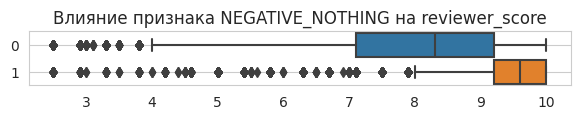

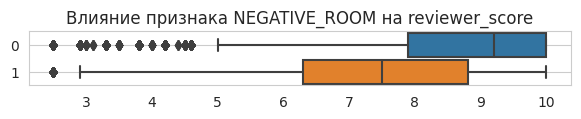

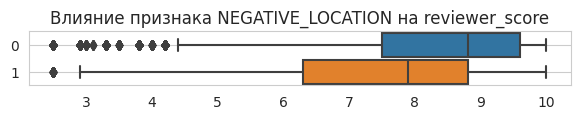

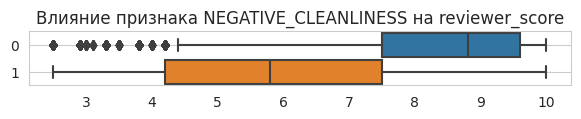

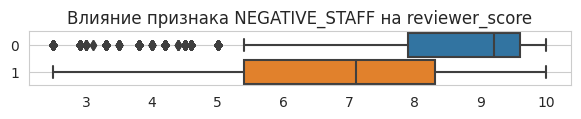

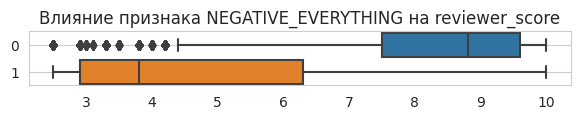

In [149]:
for feature in ['negative_nothing', 'negative_room',              #'negative_breakfast', 
                'negative_location','negative_cleanliness',
                'negative_staff',  'negative_everything']:        #negative_features_list:
    fig = plt.figure(figsize=(7, 0.7))
    boxplot = sns.boxplot(
        data=hotels,
        y=feature,
        x='reviewer_score',
        orient='h',
        width=0.9)
    boxplot.set_title('Влияние признака '+feature.upper()+' на reviewer_score');
    boxplot.set_xlabel('');
    boxplot.set_ylabel('');
    boxplot.grid()

По распределениям *reviewer_score* для всех *negative*-признаков (за исключением, очевидно, *negative_nothing*) видим, что у отзывов, для которых признак принимает значение 1, величина *reviewer_score* в среднем ниже по сравнению с отзывами, для которых признак принимает значение 0. \
Судя по графикам, наиболее сильное влияние на *negative_review* оказывают замечания к чистоте в отеле (признак *negative_cleanliness*), к персоналу (*negative_staff*) и утверждения, что в отеле все плохо (*negative_everything*). \
Отличия распределений *reviewer_score* можно установить статистическими методами, проверив соответствующие гипотезы. 

Одельно посмотрим, как количество разных замечаний влияет на *reviewer_score*.

negative_total
17    32
18    15
19     8
20     5
23     2
Name: count, dtype: int64

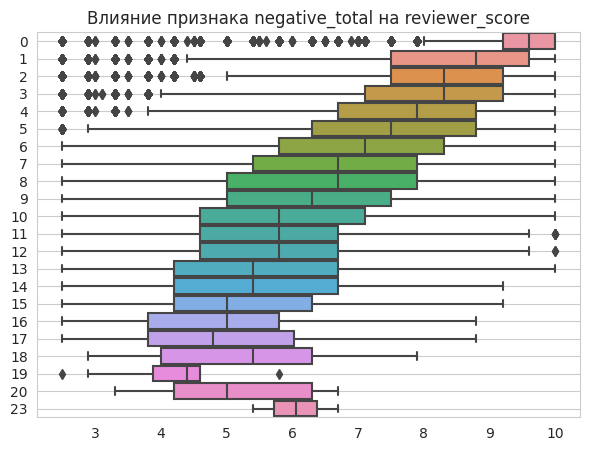

In [150]:
display(hotels['negative_total'].value_counts().tail(5))

fig = plt.figure(figsize=(7, 5))
boxplot = sns.boxplot(
    data=hotels,
    y='negative_total',
    x='reviewer_score',
    orient='h',
    width=0.9)
boxplot.set_title('Влияние признака negative_total на reviewer_score');
boxplot.set_xlabel('');
boxplot.set_ylabel('');
boxplot.grid()

Видим, что чем больше замечаний к отелю (большее значение *negative*-признаков принимают значение 1), тем ниже *reviewer_score*. Этой закономерности не совсем подчиняются отзывы с наибольшим количеством замечаний (20 и 23), скорее всего, потому что их слишком малое количество (5 и 2), чтобы делать выводы о распределении соответствующих *reviewer_score*.\
Присутствие низких оценок у отзывов, для которых *negative_total* принимает значение 0, объясняется тем, что среди этих отзывов находятся и отзывы с замечаниями к отелю, которые не подошли ни под одну формулировку *negative*-признаков.


#### Работаем с признаком *positive_review*

Cравним влияние формулировок perfect, fantastic и т.п. в *positive_review* на ретинг отеля.\

In [151]:
# Cписок ниже немного отличается от positive_formulations_list
positive_words_list = [' amazing ', ' awesome ', ' beautiful ', ' best ',
                       ' brilliant ', ' excellent ', 
                       ' fab ', ' fabulous ', ' fantastic ',' faultless ', ' fine ', 
                       ' good ', ' great ', ' happy ', ' luxury ', ' lovely ', ' nice ', 
                       ' perfect ',  ' pleasant ', ' super ', ' superb ', ' wonderful ']

really_positive_words = positive_words[['positive_word', 'review_count', 'score_mean']]
really_positive_words['really_positive'] = really_positive_words['positive_word'].apply(lambda x: 1 if ' '+x+' ' in positive_words_list else 0)
really_positive_words = really_positive_words[really_positive_words['really_positive']==1]
really_positive_words = really_positive_words.drop('really_positive', axis = 1).sort_values(by='review_count', ascending = False).reset_index(drop = True)
really_positive_words

,positive_word,review_count,score_mean
0,good,84169,8.356359
1,great,78896,9.004730
2,nice,51940,8.563993
3,excellent,47106,9.104464
4,lovely,26255,9.126574
5,perfect,19353,9.217625
6,amazing,16157,9.390363
7,fantastic,12021,9.317661
8,beautiful,10634,9.275193
9,best,8231,9.261937


Видим, что различные слова, положительно характеризующие отель, могут оказывать влияние на рейтинг. Можно:
- создать отдельные *positive*-признаки для наиболее часто употребляемых слов;
- разбить слова на несколько групп по среднему значению *reviewer_score* и создать признаки принадлежности к этим группам.

Посмотрим на очень короткие положительные отзывы.

In [152]:
positive_counts = hotels['positive_review'].value_counts().reset_index()
positive_counts['str_len'] = positive_counts['positive_review'].apply(lambda x: len(x))
positive_counts_shorts = positive_counts[positive_counts['str_len'] <=4 ].reset_index()
positive_counts_shorts

,index,positive_review,count,str_len
0,161,ok,47,4
1,1583,l,5,3
2,2071,tv,4,4
3,2690,b,3,3
4,2849,ac,3,4
5,3505,g,3,3
6,4234,e,2,3
7,4631,r,2,3
8,6575,o,2,3
9,6859,z,2,3


В данном случае (за исключением *tv*, *ac*, *ok*) не очень понятно, что значит такой отзыв, все плохо или все хорошо. Не будем  при создании новых признаков задавать для коротких отзывов отдельные условия.

По аналогии с *negative_review* в процессе рассмотрения формулировок *positive_review* сформированы списки формулировок:
- *positive_everything_list*;
- *positive_nothing_list*;
- *positive_location_list*;
- *positive_other_list*;
- *positive_check_in_out_list*.

In [153]:
positive_nothing_list = [' no_positive ',  ' all ', ' nothing all ',  ' nothing special ',
    ' nothing like ',   ' nothing much ',  ' no_like anything ',  ' no_comment ', ' no_alot ',
    ' absolutely nothing ', ' no_thing ',     ' nothing really ',' no_much ',  
    ' nothing honest ',  ' almost nothing ',' no_lot ',  ' no_much really ', ' no_good ',
    ' nothing stood ',  ' nothing ', ' no_like ', ' bad experience ',  ' too expensive ',
    ' nothing particular ', ' leaving ',' leaving hotel ']

positive_everything_list = [' place ', ' hotel ',' all ok ', ' all thing ', 
 ' best hotel ever ', ' best hotel ever stayed ',' best hotel paris ',
 ' enjoyed stay ', ' excellent all around ',' excellent every respect ',
 ' excellent place stay ',' excellent property ',
 ' good choice ', ' good quality hotel ',' good selection ',
 ' great place ',' great place stay ',
 ' highly recommend ',' highly recommended ',
 ' hotel itself ',' just ok ',' just right ',
 ' like hotel ',' liked all ', ' love ', ' love hotel ',' love place ',
 ' loved ',' loved all ',' loved hotel ',' lovely boutique hotel ',
 ' no_bad ',' no_complain ',' no_fault anything ',' whole experience ',
 ' most thing ',' overall experience ',' nothing too much trouble ',
 ' ok ',' outstanding ', ' overall ',' quality hotel ', ' simply amazing ',
 ' thank ', ' thanks ', ' very cool place ',' very nice place stay ',
 ' what no_like ', ' whole package ',' yes ']

positive_other_list = [ ' accommodation ',' rooftop ',' roof top ', ' quite ', ' ligging ',  
    ' air conditioning ',  ' plenty choice ',' l ', ' entrance ',
    ' beautiful property ',' relaxing ', ' average ', 
    ' no_star hotel ', ' classic ',' felt home ']

positive_location_list = [ ' close airport ',' close beach ',' close eiffel tower ',
 ' close gare du nord ',' close hyde park ',' close o ',' close office ',' close olympia ',
 ' close shop ',' close subway ',' close tube ',' close wembley ',' close where needed ',
 ' good access ',' la situation ',' situation ', ' close st pancras ']

positive_check_in_out_list = [' quick check ',   ' checking ',  ' easy check ',  
                              ' early check ',  ' fast check ', ' check ']

In [154]:
# # Сортировка списка для более удобного анализа его содержимого
#positive_everything_list = sorted(positive_everything_list)
#positive_everything_list

Cоздадим функцию создания признака *positive_everything*, перебирающую различные комбинации положительных характеристик и позволяющую, таким образом, сократить список *positive_everything_list*. \
В отличие от аналогичной функции для признака *negative_nothing*, не будем включать формулировки, первые слова которых задаются функцией, а последние могут быть любыми, так как последние слова в положительных отзывах могут характеризовать конкретный положительный аспект, а не весь отель (например, "*very good hotel restaurant*"). 

In [155]:
# Создаем такой же список, как positive_words_list,
# с "very" и "just",добавляем к positive_words_list
very_positive_words_list = []
for word in positive_words_list:
    very_positive_words_list.append(' very'+word)
    very_positive_words_list.append(' just'+word)
    very_positive_words_list.append(' just very'+word)
    very_positive_words_list.append(' really'+word)
    very_positive_words_list.append(' really very'+word)
positive_words_list = positive_words_list+very_positive_words_list

# Функция для создания признака positive_everything
def define_positive_everything(review):
    if review in positive_everything_list:
        return 1
    elif 'everything' in review:
        return 1
    for word in positive_words_list:
        if review in [word, word + 'hotel ', word + 'place ', word + 'experience ', word + 'stay ',
                    ' hotel'+word, ' place' +word,' experience'+word, ' stay'+word,
                    ' all'+word, ' all round'+ word, word+'all round ', word+'hotel all round ', 
                      ' hotel'+word+'all round',  ' place'+word+'all round',
                      ' whole experience'+word, ' overall'+word, ' overall experience'+word,
                      word + 'every way ', ' whole experience was'+word, 
                      ' all was'+word, ' overall experience was'+word]:
            return 1
    return 0

In [156]:
# # Сортировка списка для более удобного анализа его содержимого
# positive_formulations_list = sorted(positive_formulations_list)
# positive_formulations_list

Создаем *positive*-признаки.
- **Признаки *общего характера*:**
 - *positive_nothing*;
 - *positive_everything*;
 - *positive_price*;
 - *positive_location*;
 - *positive_cleanliness*;
 - *positive_small*;
 - *positive_long_review*;
 - *positive_quiet*;
 - *positive_parking*;
 - *positive_other*;


- **Персонал/сервиc/уют:**
 - *positive_staff*;
 - *positive_service*;
 - *positive_comfortable*;
 - *positive_atmosphere*;
 - *positive_check_in_out*;
 
 
- **Еда:**
 - *positive_breakfast*;
 - *positive_food*;
 - *positive_bar*;
 - *positive_restaurant*;
 
 
- **Номер:**
 - *positive_room*;
 - *positive_bed*;
 - *positive_bathroom*;
 - *positive_view*;
 - *positive_balcony*;
 - *positive_wifi*;
    

- **Бассейн/СПА:**    
 - *positive_spa*;
 - *positive_pool*;
    
    
- **Дизайн/территория:**    
 - *positive_lobby*;  
 - *positive_modern*;
 - *positive_design*;
 - *positive_area*;
 - *positive_upgrade*;   

    
- *positive_total* - сумма значений всех *negative*-признаков, за исключением *negative_nothing* (чем болшее значение принимает этот признак, тем больше замечаний к отелю).
    
    Дополнительно создадим признаки, указывающие на содержание популярных положительных характеристик (их вклад не учитывается в *positive_total*):
 - *positive_perfect*;
 - *positive_fantastic*;
 - *positive_good*;
 - *positive_excellent*;
 - *positive_great*.

In [157]:
def define_positives(df):
    df['positive_nothing'] = df['positive_review'].apply(lambda x: 1 if x in positive_nothing_list else 0)
    df['positive_everything'] = df['positive_review'].apply(define_positive_everything)
    #df['positive_everything'] = df['positive_review'].apply(lambda x: 1 if (x in positive_everything_list)|('everything' in x)|((('hotel' in x)|('place' in x))&(x.count(' ')<3))|('whole experience was' in x) else 0.5 if len(x)==1 else 0.5 if len(x)==1 else 0)
    df['positive_price'] = df['positive_review'].apply(lambda x: 1 if (x == ' expensive ')|('cost' in x)|('cheap' in x)|('pric' in x)|('value' in x)|('money' in x) else 0)
    df['positive_location'] = df['positive_review'].apply(lambda x: 1 if (x in positive_location_list)|(' transport ' in x)|(' milan' in x)|(' metro ' in x)|(' station ' in x)|(' underground ' in x)|('closenes' in x)|(' localiz' in x)|(' localis' in x)|('proximit' in x)|('easy get' in x)|(' locat' in x)|(' positio' in x)|(' central ' in x)|(' localit' in x)|(' situate' in x)|(' near ' in x)|(' center ' in x)|(' city' in x)|(' london ' in x)|(' paris ' in x) else 0)
    
    df['positive_staff'] = df['positive_review'].apply(lambda x: 1 if ('helpful' in x)|('people' in x)|('personnel' in x)|('staff' in x)|('recept' in x)|('concierg' in x)|('employee' in x)|(x=='people') else 0)
    df['positive_service'] = df['positive_review'].apply(lambda x: 1 if ('service' in x)|('facilit' in x) else 0)
    df['positive_comfortable'] = df['positive_review'].apply(lambda x: 1 if ('cozines' in x)|('comfy' in x)|('comfort' in x)|('convenien' in x) else 0)
    df['positive_atmosphere'] = df['positive_review'].apply(lambda x: 1 if ('charm' in x)|('welcom' in x)|('attention' in x)|('friendl' in x)|('hospitalit' in x)|('atmosph' in x)|('ambien' in x) else 0) 

    df['positive_breakfast'] = df['positive_review'].apply(lambda x: 1 if 'breakfast' in x else 0)  
    df['positive_food'] = df['positive_review'].apply(lambda x: 1 if (' coffee ' in x)|('pizza' in x)|(' food ' in x)|('cook' in x)|('tea' in x) else 0)
    df['positive_bar'] = df['positive_review'].apply(lambda x: 1 if (' bar ' in x) else 0)
    df['positive_restaurant'] = df['positive_review'].apply(lambda x: 1 if 'restaurant'in x else 0)
    
    df['positive_bed'] = df['positive_review'].apply(lambda x: 1 if (' bed ' in x)|('pillow' in x) else 0)
    df['positive_bathroom'] = df['positive_review'].apply(lambda x: 1 if (' bath' in x)|('shower' in x) else 0)
    df['positive_room'] = df['positive_review'].apply(lambda x: 1 if (' room ' in x)|(' bedroom ' in x) else 0) 
    df['positive_view'] = df['positive_review'].apply(lambda x: 1 if (' view ' in x)|(' window ' in x) else 0)
    df['positive_balcony'] = df['positive_review'].apply(lambda x: 1 if (' balcon' in x)|(' terrac' in x) else 0)
    df['positive_wifi'] = df['positive_review'].apply(lambda x: 1 if (' tv ' in x)|('wifi' in x)|(' wi fi ' in x)|(' internet' in x) else 0)
    
    df['positive_cleanliness'] = df['positive_review'].apply(lambda x: 1 if 'clean' in x else 0)
    
    
    df['positive_spa'] = df['positive_review'].apply(lambda x: 1 if ('spa' in x)|('sauna' in x) else 0)
    df['positive_pool'] = df['positive_review'].apply(lambda x: 1 if 'pool' in x else 0)
    
    df['positive_lobby'] = df['positive_review'].apply(lambda x: 1 if ('foyer' in x)|('lobby' in x)|('lounge' in x) else 0)
   
    df['positive_modern'] = df['positive_review'].apply(lambda x: 1 if ('modern' in x)|(' new ' in x) else 0)
    df['positive_design'] = df['positive_review'].apply(lambda x: 1 if ('design'in x)|('interior' in x)|('decor' in x)|('styl' in x) else 0)
    df['positive_area'] = df['positive_review'].apply(lambda x: 1 if (' elevator ' in x)|(' building ' in x)|('area' in x)|('garden' in x)|('environmen' in x) else 0)
    df['positive_upgrade'] = df['positive_review'].apply(lambda x: 1 if 'upgrad' in x else 0)
    df['positive_quiet'] = df['positive_review'].apply(lambda x: 1 if ('quiet' in x)|( ' quite place ' in x)|( 'calm' in x) else 0)
    
    df['positive_parking'] = df['positive_review'].apply(lambda x: 1 if ('parking' in x)|(' car ' in x) else 0)
    
    df['positive_small'] = df['positive_review'].apply(lambda x: 1 if ('small' in x)|('little' in x)|('tiny' in x) else 0)

    df['positive_long_review'] = df['positive_review'].apply(lambda x: 1 if x.count(' ') > 50 else 0)
    df['positive_check_in_out'] = df['positive_review'].apply(lambda x: 1 if ('check_in' in x)|(' checking ' in x)|('check_out' in x)|(x in positive_check_in_out_list) else 0)
    df['positive_other'] = df['positive_review'].apply(lambda x: 1 if (x in positive_other_list)|(' above ' in x)|(' variet' in x)|(' efficien' in x)|(' no_eat ' in x)|(' gym ' in x)|(' kitchen ' in x) else 0)
    
    # Создадим новый признак, чтобы посмотреть распределение количества позитивных формулировок
    df['positive_total'] = df['positive_location']+df['positive_staff']+df['positive_everything']\
    +df['positive_breakfast']+df['positive_bed']+df['positive_cleanliness']+df['positive_room']\
    +df['positive_price']+df['positive_bathroom']+df['positive_service']+df['positive_view']\
    +df['positive_comfortable']+df['positive_food']+df['positive_spa']+df['positive_design']\
    +df['positive_pool']+df['positive_wifi']+df['positive_bar']+df['positive_lobby']\
    +df['positive_atmosphere']+df['positive_modern']+df['positive_area']+df['positive_upgrade']\
    +df['positive_quiet']+df['positive_parking']+df['positive_restaurant']+df['positive_small']\
    +df['positive_balcony']+df['positive_long_review']\
    +df['positive_check_in_out']+df['positive_other']
    
    #Дополнительно создадим признаки, указывающие на содержание популярных положительных характеристик
    # Их вклад не учитывается в positive_total
    df['positive_perfect'] = df['positive_review'].apply(lambda x: 1 if 'perfect' in x else 0)
    df['positive_fantastic'] = df['positive_review'].apply(lambda x: 1 if 'fantastic' in x else 0)
    df['positive_good'] = df['positive_review'].apply(lambda x: 1 if 'good' in x else 0)
    df['positive_excellent'] = df['positive_review'].apply(lambda x: 1 if 'excellent' in x else 0)
    df['positive_great'] = df['positive_review'].apply(lambda x: 1 if 'great' in x else 0)
    
    #df['review_total_positive_word_counts_2'] = df.apply(lambda row: word_counts_correction(row['positive_review_2'], row['positive_nothing']), axis = 1)
    #df = df.drop(['positive_review', 'positive_review_2'], axis = 1)
    return df

In [158]:
# Применяем функцию define_positives
hotels = define_positives(hotels) 

Проанализируем результаты проделанной с признаком positive_review работы.

In [159]:
# Рассмотрим формулировки, которые оказались не отражены в новых negative-признаках
#(для которых все новые признаки равны 0)
mask = (hotels['positive_total'] == 0) & (hotels['positive_nothing'] == 0)
hotels_unused_positives = hotels[mask]
print('Всего строк датасета c необработанным признаком positive_review:')
print(hotels_unused_positives.shape[0]) #
print()
print('Всего различных необработанных формулировок positive_review:')
print(hotels_unused_positives['positive_review'].value_counts().reset_index().shape[0]) #.head(20))
print()
print('Присутствий в датасете наиболее популярной необработанной формулировки positive_review:')
(hotels_unused_positives['positive_review'].value_counts().reset_index()['count'].max())

Всего строк датасета c необработанным признаком positive_review:
12151

Всего различных необработанных формулировок positive_review:
11410

Присутствий в датасете наиболее популярной необработанной формулировки positive_review:


4

Ниже инструмент для пополнения списка *positive_everything* и для анализа формулировок, которые не соответствуют ни одному из созданных признаков.

In [160]:
# Выводим список из наиболее популярных "неохваченных" формулировок
#display(hotels_unused_positives['positive_review'].value_counts().reset_index().head(60)['positive_review'].tolist())

In [161]:
positive_features_list = ['positive_nothing', 'positive_everything','positive_price',
                    'positive_location','positive_cleanliness','positive_small',
                    'positive_long_review','positive_quiet','positive_parking',
                    'positive_other','positive_staff',
                    'positive_service','positive_comfortable','positive_atmosphere',
                    'positive_check_in_out','positive_breakfast','positive_food',
                    'positive_bar','positive_restaurant','positive_room',
                    'positive_bed','positive_bathroom','positive_view',
                    'positive_balcony','positive_wifi',   'positive_spa',
                    'positive_pool','positive_lobby','positive_modern',
                    'positive_design','positive_area','positive_upgrade']

positive_features_counts_list = []
for feature in positive_features_list:
    positive_features_counts_list.append((hotels[hotels[feature] == 1]).shape[0])

positive_features_dict = {'positive_feature':positive_features_list, 'count': positive_features_counts_list}
positive_features_df = pd.DataFrame(positive_features_dict)
positive_features_df = positive_features_df.sort_values(by = 'count', ascending = False).reset_index(drop = True) 
display(positive_features_df)

# Упорядочим список признаков по количеству принимаемых значений 1
#positive_features_list = list(positive_features_df['positive_feature'])

,positive_feature,count
0,positive_location,179721
1,positive_staff,155830
2,positive_room,117435
3,positive_atmosphere,78295
4,positive_comfortable,71277
5,positive_breakfast,62183
6,positive_cleanliness,55613
7,positive_bed,48023
8,positive_service,31619
9,positive_nothing,29267


Видим, что чаще всего в отзывах в качестве положительных качеств отеля пользователи называют местоположение, персонал, атмосферу и непосредственно номер.  

Посмотрим, как распределения *positive*-признаков влияют на *reviewer_score*. \
*(Визуализируем влияние только некоторых признаков, графики в основном похожи).*

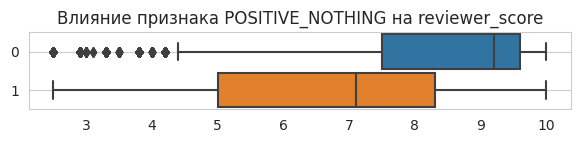

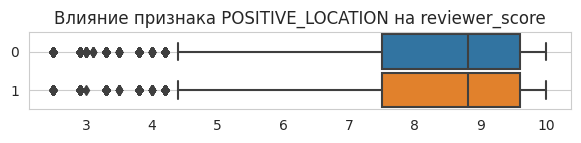

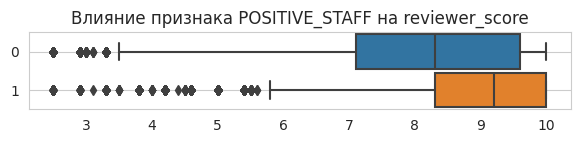

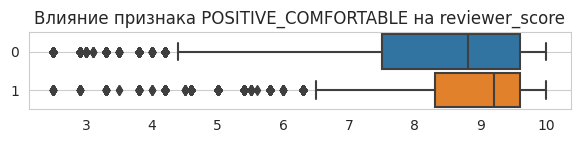

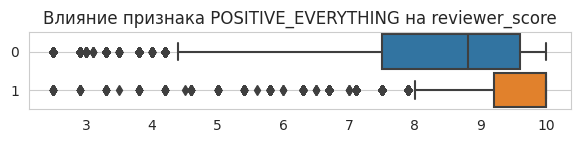

In [162]:
for feature in ['positive_nothing','positive_location', 'positive_staff', 
                'positive_comfortable', 'positive_everything']:    #positive_features_list:
    fig = plt.figure(figsize=(7, 1))
    boxplot = sns.boxplot(
        data=hotels,
        y=feature,
        x='reviewer_score',
        orient='h',
        width=0.9)
    boxplot.set_title('Влияние признака '+feature.upper()+' на reviewer_score');
    boxplot.set_xlabel('');
    boxplot.set_ylabel('');
    boxplot.grid()

По распределениям *reviewer_score* для всех *positive*-признаков (за исключением *positive_nothing* и, вероятно, *positive_location*) видим, что у отзывов, для которых признак принимает значение 1, величина *reviewer_score* в среднем выше по сравнению с отзывами, для которых признак принимает значение 0. Наиболее явно это видно по признаку *positive_everything*.

По распределению *reviewer_score* для признака *positive_location*,который принимает наибольшее кличество значений 1 (почти половину) среди всех *positive*-признаков, не очевидно, влияет ли положительная оценка местоположения отеля на его рейтинг. Проверим гипотезу об одинаковости распределений *reviewer_score* для отзывов, у которых *positive_location* = 1 и у которых *positive_location* = 0.

***Нулевая гипотеза:***
Распределения *reviewer_score* для отзывов, у которых *positive_location* = 1 и *positive_location* = 0, являются одинаковыми.

***Альтернативная гипотеза:***
Распределения *reviewer_score* для отзывов, у которых *positive_location* = 1 \
и *positive_location* = 0, являются различными.

Уровень значимости примем равным 0.05.

В первую очередь проверим распределения на нормальность. Построим гистограммы распределений признака *reviewer_score* для двух выборок.

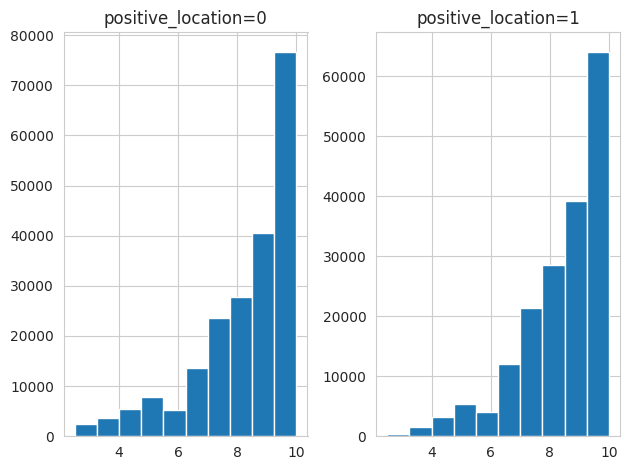

In [163]:
location_0 = hotels[hotels['positive_location']==0]
location_1 = hotels[hotels['positive_location']==1]

location_0 = location_0[['reviewer_score']]
location_1 = location_1[['reviewer_score']]

# # Построим гистограммы распределений признаков total_number_of_reviews и additional_number_of_scoring
plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
plt.hist(location_0['reviewer_score']) # qq plot
plt.title('positive_location=0')
plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(location_1['reviewer_score']) # гистограмма распределения признака
plt.title('positive_location=1')
plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
plt.show() # просмотр графика
# # Видим, что распределения не являются нормальными

Видим, что распределения нормальными не являются. \
Будем применять U-критерий Манна — Уитни.

In [164]:
alpha = 0.05 # задаём уровень значимости

# загружаем данные
location_0_score = location_0['reviewer_score'].tolist()
location_1_score = location_1['reviewer_score'].tolist()

# проводим тест
_, p = stats.mannwhitneyu(location_0_score, location_1_score)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Выяснили, что распределения *reviewer_score* для отзывов, у которых *positive_location* = 1 
и *positive_location* = 0, все-таки являются различными. Таким образом, хорошее расположение отеля (по отзывам) влияет на его рейтинг.

positive_total
19    21
20     9
21     4
23     2
24     1
Name: count, dtype: int64

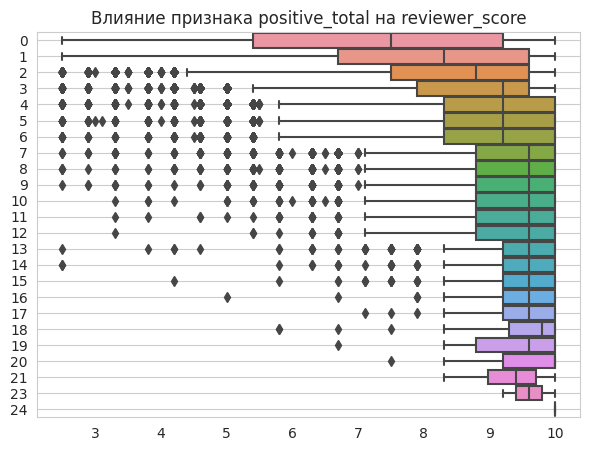

In [165]:
display(hotels['positive_total'].value_counts().tail(5))

fig = plt.figure(figsize=(7, 5))
boxplot = sns.boxplot(
    data=hotels,
    y='positive_total',
    x='reviewer_score',
    orient='h',
    width=0.9)
boxplot.set_title('Влияние признака positive_total на reviewer_score');
boxplot.set_xlabel('');
boxplot.set_ylabel('');
boxplot.grid()

Видим, что чем больше хороших свойств отеля указано в *positive_review*, тем в среднем выше *reviewer_score*. 

При более аккуратной работе с новыми признаками можно рассмотреть "противоречивые" отзывы, у которых *negative_nothing* = 1 и *negative_total* > 0 (аналогично для *positive*-признаков). Скорее всего, эти отзывы были обработанны некорректно и следует исправить ошибки.

## Удаление признаков по результатам обучения модели
#### Функция *delete_features*
На данный момент в датасете имеется 165 признаков. На их основе было выполнено обучение модели и проведен анализ "важности" признаков для обученной модели с использованием инструмента *regr.feature_importances_*. Было выяснено, что присутствие подавляющего большинства созданных признаков оказывает относительно небольшое влияние на качество модели (*однако может позволить победить в соревновании!*). В таблице ниже приведена зависимость score в соревновании от количества использованных при обучении модели признаков. В каждом случае использовались, конечно, наиболее важные признаки; менее существенные были удалены. Исключение - попытка удалить признак *hotel_popularity*, который скоррелирован с признаками *total_number_of_reviews* и *additional number of scoring*.

| Количество признаков | Score |
|---|---|
|165 |  10.49701 |
|115     | 10.50887   |
|65  | 10.51827    |
|64 (без hotel_popularity)| 10,51403|
|50|10.54821|
|25 | 10.65343   |
|15   |  10.79597   |

Представляется целесообразным исследовать корреляции между новыми признаками, отражающими "вклад" каждого слова *positive_review* и *negative_review* в *reviewer_score*. Вероятно, удаление некоторых из них может улучшить результат.

В настоящий момент оставим 64 наиболее значимых признака, остальные удалим.\
Также удалим не удаленные ранее нечисловые признаки.


In [166]:
def drop_features(df):
    df = df.drop(['hotel_name','room_tag', 'reviewer_nationality', 
                  'negative_review','positive_review'], axis = 1)
    df = df.drop(['leisure_trip',
 'room_tag_other',
 'business_trip',
 'hotel_country_United Kingdom',
 'native_hotel',
 'negative_room',
 'positive_room',
 'family_with_young_children',
 'group',
 'negative_everything',
 'hotel_country_Netherlands',
 'hotel_country_Spain',
 'hotel_country_France',
 'negative_price',
 'negative_nothing',
 'positive_staff',
 'hotel_country_Austria',
 'room_tag_Double Room',
 'hotel_country_Italy',
 'room_tag_Standard Double Room',
 'negative_small',
 'positive_breakfast',
 'room_tag_Superior Double Room',
 'negative_location',
 'negative_beds',
 'positive_location',
 'positive_comfortable',
 'room_tag_Deluxe Double Room',
 'positive_good',
 'positive_cleanliness',
 'family_with_older_children',
 'negative_breakfast',
 'negative_service',
 'negative_staff',
 'room_tag_Standard Double or Twin Room',
 'positive_bed',
 'room_tag_Double or Twin Room',
 'negative_bathroom',
 'negative_other',
 'negative_old',
 'positive_atmosphere',
 'negative_noise',
 'positive_great',
 'room_tag_Classic Double Room',
 'negative_food',
 'negative_wifi',
 'positive_service',
 'negative_complectation',
 'negative_weather',
 'room_tag_Superior Double or Twin Room',
 'negative_bar',
 'room_tag_2 rooms',
 'positive_food',
 'room_tag_Standard Twin Room',
 'negative_air_conditioning',
 'positive_small',
 'positive_bathroom',
 'positive_area',
 'negative_area',
 'negative_restaurant',
 'positive_view',
 'negative_shower',
 'negative_comfort',
 'positive_bar',
 'positive_price',
 'positive_excellent',
 'negative_lift',
 'positive_restaurant',
 'negative_drinks',
 'positive_quiet',
 'positive_spa',
 'negative_personal_story',
 'positive_design',
 'positive_modern',
 'positive_other',
 'negative_view',
 'negative_parking',
 'negative_construction',
 'positive_wifi',
 'negative_design',
 'positive_nothing',
 'negative_pool',
 'positive_lobby',
 'positive_pool',
 'positive_perfect',
 'positive_everything',
 'negative_people',
 'negative_check_in_out',
 'negative_spa',
 'negative_cleanliness',
 'positive_balcony',
 'positive_upgrade',
 'travelers_with_friends',
 'positive_parking',
 'with_a_pet',
 'positive_fantastic',
 'negative_long_review',
 'negative_gym',
 'positive_check_in_out',
 'positive_long_review', 
 'hotel_popularity'], axis = 1)
    return df

hotels = drop_features(hotels)
hotels.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,nationality_score,submitted_from_a_mobile_device,stayed_nights,couple,solo_traveler,room_tag_delta_mean,room_tag_score_mean,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum,pos_delta_mean_mean,pos_delta_mean_max,pos_delta_mean_min,pos_delta_mean_sum,pos_score_mean_mean,pos_score_mean_max,pos_score_mean_min,pos_score_mean_sum,pos_delta_part_mean_mean,pos_delta_part_mean_max,pos_delta_part_mean_min,pos_delta_part_mean_sum,pos_score_part_mean_mean,pos_score_part_mean_max,pos_score_part_mean_min,pos_score_part_mean_sum,rew_delta_mean_mean,rew_delta_mean_max,rew_delta_mean_min,rew_delta_mean_sum,rew_score_mean_mean,rew_score_mean_max,rew_score_mean_min,rew_score_mean_sum,rew_delta_part_mean_mean,rew_delta_part_mean_max,rew_delta_part_mean_min,rew_delta_part_mean_sum,rew_score_part_mean_mean,rew_score_part_mean_max,rew_score_part_mean_min,rew_score_part_mean_sum,negative_total,positive_total
0,581,8.4,3,1994,4,7,10.0,531,8.488676,1,2.0,1,0,0.115285,9.046041,-0.673559,-0.673559,-0.673559,-0.673559,7.737881,7.737881,7.737881,7.737881,0.160235,0.160235,0.160235,0.160235,1.900479,1.900479,1.900479,1.900479,0.606288,0.748134,0.464442,1.212576,9.167293,9.390363,8.944223,18.334586,0.049638,0.070621,0.028655,0.099276,0.988980,0.997587,0.980374,1.977961,0.107567,0.719692,-0.531192,0.322702,8.604200,9.357839,7.875911,25.812600,0.024070,0.054463,-0.001274,0.072211,0.505210,0.622816,0.33980,1.515629,0,1
1,299,8.3,3,1361,2,14,6.3,203,8.488676,0,1.0,1,0,0.011470,8.256530,-1.004827,-0.514008,-1.495646,-2.009654,7.283166,7.838600,6.727732,14.566332,-0.053873,-0.008976,-0.098771,-0.107747,0.830313,0.947872,0.712755,1.660626,0.035458,0.035458,0.035458,0.035458,8.426522,8.426522,8.426522,8.426522,-0.119745,-0.119745,-0.119745,-0.119745,1.585845,1.585845,1.585845,1.585845,-0.520446,-0.010629,-1.516488,-1.561337,7.811337,8.374718,6.703869,23.434012,-0.022759,0.005778,-0.079199,-0.068276,0.544474,0.699085,0.41812,1.633422,2,1


# Обучение и тестирование модели

In [167]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
y = hotels['reviewer_score'] 
X = hotels.drop(['reviewer_score'], axis = 1)  

In [168]:
X.shape

(386496, 64)

При сравнении MinMaxScaler и RobustScaler было установлено, что для данного датасета применение MinMaxScaler приводит к несколько лучшим результатам.

In [169]:
# Нормализуем X. Инициализируем нормализатор MinMaxScaler
column_list = list(X)
mm_scaler = preprocessing.MinMaxScaler()

# обучаем нормализотор
mm_scaler.fit(X)
# кодируем исходный датасет
X = mm_scaler.transform(X)

# Преобразуем промежуточный датасет в полноценный датафрейм
X = pd.DataFrame(X, columns=column_list)

In [170]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=10,n_jobs=-1,max_features = 0.33)# X.shape[1]//3)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.10711543831919168


"Подгоним" полученные *reviewer_score* к диапазону значений, представленному в датасете. Это способствует небольшому снижению MAPE.

In [171]:
y_list = []
for x in y_pred:
    if x>10:
        y_list.append(10)
    elif x<2.5:
        y_list.append(2.5)
    else:
        y_list.append(round(x, 1))
        
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_list))

MAPE: 0.10707770507572478


## Все преобразования датасета объединим в одну функцию

In [172]:
def df_transformation(df):
    df = define_days_since_review_num(df)
    df = define_hotel_country(df)
    df = hotel_country_encoder(df)
# Работаем с reviewer_nationality    
    df = define_native_hotel(df)
    df = define_other_nationality(df)
    df = add_nationality_score(df)
    #df = correct_nationality(df)
    #df = reviewer_nationality_encoder(df)
    df = define_hotel_popularity(df)
#  Работаем с тегами
    df = define_tags_1(df)
    df = define_room_tag(df)
    df = define_room_tag_features(df)
    df = correct_room_tag(df)
    df = room_type_encoder(df)
# Работаем с negative_review и positive_review
    df = review_changes_1(df)
    df = define_negative_review_weight(df)
    df = define_positive_review_weight(df)
    df = define_review_weight(df)
    df = define_negatives(df) 
    df = define_positives(df)
    df = drop_features(df)
    return df

# Преобразования датасета X_val

In [173]:
X_val = pd.read_csv(input_dir + 'hotels_test.csv')
X_val = df_transformation(X_val)

In [174]:
X_val.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,nationality_score,submitted_from_a_mobile_device,stayed_nights,couple,solo_traveler,room_tag_delta_mean,room_tag_score_mean,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum,pos_delta_mean_mean,pos_delta_mean_max,pos_delta_mean_min,pos_delta_mean_sum,pos_score_mean_mean,pos_score_mean_max,pos_score_mean_min,pos_score_mean_sum,pos_delta_part_mean_mean,pos_delta_part_mean_max,pos_delta_part_mean_min,pos_delta_part_mean_sum,pos_score_part_mean_mean,pos_score_part_mean_max,pos_score_part_mean_min,pos_score_part_mean_sum,rew_delta_mean_mean,rew_delta_mean_max,rew_delta_mean_min,rew_delta_mean_sum,rew_score_mean_mean,rew_score_mean_max,rew_score_mean_min,rew_score_mean_sum,rew_delta_part_mean_mean,rew_delta_part_mean_max,rew_delta_part_mean_min,rew_delta_part_mean_sum,rew_score_part_mean_mean,rew_score_part_mean_max,rew_score_part_mean_min,rew_score_part_mean_sum,negative_total,positive_total
0,904,8.1,52,16670,62,1,13,8.488676,0,2.0,1,0,-0.014402,8.282642,-0.851534,-0.072236,-1.791011,-25.546024,7.474267,8.372482,6.433708,224.228020,-0.014902,0.015314,-0.063879,-0.447061,0.483298,1.129517,0.313369,14.498930,0.396901,0.973054,0.018952,15.479154,8.847124,9.567572,8.356359,345.037821,0.009948,0.054240,-0.038030,0.387975,0.622796,0.997587,0.339133,24.289063,-0.168202,0.742141,-1.410088,-11.605963,8.226659,9.368456,6.864474,567.639456,0.001351,0.043988,-0.042434,0.093200,0.335070,0.586105,0.208083,23.119823,3,8
1,612,8.6,10,5018,0,7,234,8.165436,0,1.0,0,0,0.019498,8.129542,-1.351350,-1.060363,-1.642857,-6.756751,6.907914,7.183246,6.729049,34.539569,-0.044508,-0.022632,-0.066708,-0.222542,0.493876,0.712063,0.306625,2.469382,-1.334673,-1.334673,-1.334673,-1.334673,6.888889,6.888889,6.888889,6.888889,-1.334534,-1.334534,-1.334534,-1.334534,6.888720,6.888720,6.888720,6.888720,-1.012743,-0.392342,-1.713699,-6.076457,7.298382,8.000450,6.702740,43.790292,-0.046050,-0.003113,-0.131418,-0.276303,0.417954,1.024539,0.239713,2.507727,1,0


In [175]:
# Нормализуем X_val
# инициализируем нормализатор MinMaxScaler
column_list = list(X_val)
#mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
X_val = mm_scaler.transform(X_val)

# Преобразуем промежуточный датасет в полноценный датафрейм
X_val = pd.DataFrame(X_val, columns=column_list)
X_val.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,nationality_score,submitted_from_a_mobile_device,stayed_nights,couple,solo_traveler,room_tag_delta_mean,room_tag_score_mean,neg_delta_mean_mean,neg_delta_mean_max,neg_delta_mean_min,neg_delta_mean_sum,neg_score_mean_mean,neg_score_mean_max,neg_score_mean_min,neg_score_mean_sum,neg_delta_part_mean_mean,neg_delta_part_mean_max,neg_delta_part_mean_min,neg_delta_part_mean_sum,neg_score_part_mean_mean,neg_score_part_mean_max,neg_score_part_mean_min,neg_score_part_mean_sum,pos_delta_mean_mean,pos_delta_mean_max,pos_delta_mean_min,pos_delta_mean_sum,pos_score_mean_mean,pos_score_mean_max,pos_score_mean_min,pos_score_mean_sum,pos_delta_part_mean_mean,pos_delta_part_mean_max,pos_delta_part_mean_min,pos_delta_part_mean_sum,pos_score_part_mean_mean,pos_score_part_mean_max,pos_score_part_mean_min,pos_score_part_mean_sum,rew_delta_mean_mean,rew_delta_mean_max,rew_delta_mean_min,rew_delta_mean_sum,rew_score_mean_mean,rew_score_mean_max,rew_score_mean_min,rew_score_mean_sum,rew_delta_part_mean_mean,rew_delta_part_mean_max,rew_delta_part_mean_min,rew_delta_part_mean_sum,rew_score_part_mean_mean,rew_score_part_mean_max,rew_score_part_mean_min,rew_score_part_mean_sum,negative_total,positive_total
0,0.336815,0.630435,0.127451,1.000000,0.156962,0.000000,0.017808,0.567871,0.0,0.034483,1.0,0.0,0.576074,0.662734,0.548767,0.685458,0.589945,0.891056,0.549388,0.691758,0.543831,0.122022,0.580075,0.593261,0.558702,0.744610,0.033865,0.110315,0.034805,0.113717,0.800720,0.828419,0.733999,0.320836,0.812842,0.926337,0.742043,0.152495,0.874387,0.885406,0.862452,0.563666,0.051178,0.107931,0.041346,0.164730,0.65769,0.726552,0.672157,0.930464,0.673090,0.856467,0.599246,0.162958,0.676404,0.523397,0.865518,0.793629,0.08409,0.164359,0.095829,0.169914,0.130435,0.333333
1,0.227900,0.739130,0.024510,0.299212,0.000000,0.016949,0.320548,0.440913,0.0,0.000000,0.0,0.0,0.583995,0.630137,0.454462,0.501791,0.608183,0.955723,0.436419,0.466524,0.584661,0.016576,0.567155,0.576701,0.557467,0.765186,0.035116,0.060929,0.034024,0.018068,0.484317,0.442845,0.488814,0.206472,0.475431,0.470032,0.501999,0.001234,0.539918,0.539918,0.539918,0.397064,1.000000,1.000000,1.000000,0.045319,0.42928,0.479926,0.626705,0.947215,0.435216,0.545557,0.574676,0.009544,0.580131,0.408861,0.773857,0.744965,0.13298,0.347443,0.115186,0.015865,0.043478,0.000000


## Обучение модели на полном наборе данных

In [176]:
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1,max_features=0.33)#X.shape[1]//3)  # Создаём модель  
regr.fit(X, y)  

RandomForestRegressor(max_features=0.33, n_jobs=-1)

Посмотрим на "важность" признаков для обученной модели.

In [180]:
importances=regr.feature_importances_
importances #[1]
dict = {'feature': list(X), 'importance': importances}
df = pd.DataFrame(dict)
df = df.sort_values(by = 'importance', ascending = False).reset_index(drop = True)
df 

,feature,importance
0,rew_delta_part_mean_mean,0.148558
1,rew_delta_part_mean_sum,0.100408
2,rew_score_mean_mean,0.093185
3,rew_delta_mean_mean,0.053517
4,neg_score_mean_mean,0.032869
...,...,...
59,review_total_positive_word_counts,0.003605
60,pos_delta_part_mean_min,0.003522
61,submitted_from_a_mobile_device,0.001333
62,couple,0.001288


**Вывод**: наиболее полезными для построения модели оказались признаки, отражающие "вклад" каждого слова *positive_review* и *negative_review* в *reviewer_score*.\
Удаление наименее полезных признаков не приводит к улучшению качетства модели, а в небольшой степени его снижает (score увеличивается на величину порядка 0.01 при удалении 50 признаков). \
Из проведенных ранее операций с признаками нет острой необходимости выполнять:
 - создание признаков страны расположения отеля и признака *native_hotel*(т.е. вся работа с признаками *hotel_adress*, *lng*, *lat*);
 - однократное кодирование популярных тегов, связанных с типом номера;
 - создание бинарных *positive*- и *negative*-признаков, отражающих конкретные положительные и отрицательные характеристики отеля (достаточно иметь связанные с ними признаки *positive_total* и *negative-total*). 


In [178]:
# Небольшая "подгонка" полученных значений
y_val = regr.predict(X_val)

y_list = []
for x in y_val:
    if x>10:
        y_list.append(10)
    elif x<2.5:
        y_list.append(2.5)
    else:
        y_list.append(round(x, 1))

In [179]:
submission = pd.read_csv(input_dir + 'submission.csv')
submission['reviewer_score'] = y_list #.data[:, 0]
submission.to_csv('submission.csv', index = False) #/kaggle/working/